## Maszyna wektorów nośnych

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from typing import Tuple

#### Zbiory danych

In [361]:
iris = datasets.load_iris()
breast_cancer = datasets.load_breast_cancer()
MNIST = datasets.fetch_openml('mnist_784')
digits = datasets.load_digits()
titanic = sns.load_dataset('titanic')
heart_disease = pd.read_csv('heart.csv')

#### Notatki

Algorytmy klasyfikacji takie jak regresja logistyczna wymagają ręcznej inżynierii cech w celu klasyfikacji danych z nieliniową granicą. Polega to na rozszerzenie przestrzeni cech, np. użycie potęg cech, iloczynów cech, funkcji trygonometrycznych itp. w celu zwiększenia złożoności modelu.

Algorytm SVM pozwala na klasyfikację danych z nieliniową granicą bez konieczności ręcznej inżynierii cech - wykorzystuje do tego tzw. funkcje jądrowe (ang. kernel functions).

Algorytm polega na znalezieniu optymalnej hiperpłaszczyzny $(d-1)$-wymiarowej w przestrzeni $d$-wymiarowej, która najlepiej separuje dane.
Algorytm stosuje się przede wszystkim do klasyfikacji binarnej - znajduje hiperpłaszczyznę, która najlepiej separuje dwie klasy (w przypadku zbioru z dwoma klasami). W przypadku większej ilości klas możemy zbudować wiele klasyfikatorów realizujących zadanie klasyfikowania - punkt należy do klasy A lub punkt nie należy do klasy A (tzw. metoda jeden przeciw wszystkim).

Najprostsza wersja algorytmu SVM to klasyfikator liniowy, który szuka hiperpłaszczyzny separującej dane maksymalizując odległość między hiperpłaszczyzną a najbliższymi punktami z obu klas (tzw. margines). W przypadku, gdy dane są liniowo separowalne, algorytm znajduje hiperpłaszczyznę, która maksymalizuje margines. 

W przypadku, gdy dane nie są liniowo separowalne, stosuje się tzw. funkcje jądrowe, które mapują dane do przestrzeni o wyższej wymiarowości, gdzie dane są lepiej separowalne, dzięki czemu można rozwiązać problem klasyfikacji danych z nieliniową granicą.

#### Własna implementacja algorytmu SVM

In [362]:
class SVM:
    """
    Support Vector Machine classifier resolving the dual optimization problem.
    """
    def __init__(self, learning_rate: float = 0.001, epochs: int = 1000, C: float = 1.0, kernel='linear', gamma='scale', degree: int = 3, coef0: float = 1.0, seed: int = 1234):
        """
        :param learning_rate: Learning rate parameter.
        :param epochs: Number of epochs.
        :param C: Regularization parameter.
        :param kernel: Kernel type. Default: 'linear'. Options: 'linear', 'rbf', 'sigmoid', 'poly'.
        :param gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid' kernels.
        :param degree: Degree parameter for 'poly' kernel.
        :param coef0: Independent term in 'poly' and 'sigmoid' kernels.
        :param seed: Random seed for reproducibility.
        """
        # Random seed
        self.rng = np.random.RandomState(seed)
        
        # Learning rate
        self.learning_rate = learning_rate
        
        # Number of epochs (iterations)
        self.epochs = epochs
        
        # Regularization parameter
        self.C = C
        
        # Kernel
        self.kernel = self._select_kernel(kernel)
            
        # Kernel coefficients
        self.gamma = gamma # 'rbf', 'poly', 'sigmoid'
        self.coef0 = coef0 # 'poly', 'sigmoid'
        self.degree = degree # 'poly'
            
        # Model parameters
        self.alpha = None # Lagrange multipliers
        self.b = None # Bias term
        self.support_vectors_ = None
        
        # Number of samples and features
        self.n_samples = None
        self.n_features = None
        
        # Training data
        self.X = None
        self.y = None
        
        # Kernel matrix
        self.K = None
        
    def fit(self, X, y, plot_loss=False):
        """
        Fit the model given the training data.
        """
        # Training data
        self.X = X
        self.y = y
        
        # Number of samples and features
        self.n_samples, self.n_features = X.shape
        
        # Initialize parameters
        self.alpha = np.ones(self.n_samples)
        self.b = 0
        
        # Helper vector
        self.ones = np.ones(self.n_samples)
        
        # Calculate gamma parameter if set to 'scale' or 'auto'
        if self.gamma == 'scale':
            self.gamma = 1 / (self.n_samples * X.var())
        elif self.gamma == 'auto':
            self.gamma = 1 / self.n_features
            
        # Calculate kernel matrix
        self.K = np.outer(self.y, self.y) * self.kernel(self.X, self.X)
                
        # Initialize loss list
        losses = []
        
        # Training loop
        for _ in range(self.epochs):
            # Gradient
            gradient = self.ones - self.K.dot(self.alpha)
            
            # Update alpha
            self.alpha = self.alpha + self.learning_rate * gradient
            
            # Project alpha to feasible region (0, C) - KKT conditions
            self.alpha = np.clip(self.alpha, 0, self.C)
            
            # Calculate loss
            loss = self._calculate_loss()
            losses.append(loss)

        # Find support vectors and calculate bias term
        self._calculate_bias()
        
        # Loss per epochs plot
        if plot_loss:
            plt.plot(losses)
            plt.title("Loss per epochs")
            plt.show()
    
    def _calculate_bias(self):
        """
        Calculate bias term.
        """
        epsilon = 1e-8
        
        # Support vectors indices
        supportIndicies = np.where((self.alpha > epsilon) & (self.alpha < self.C - epsilon))[0]
        
        # Support vectors
        self.support_vectors_ = self.X[supportIndicies]
        
        # Bias term
        self.b = np.mean(self.y[supportIndicies] - np.dot(self.alpha * self.y, self.kernel(self.X, self.X[supportIndicies])))
        
    def _calculate_loss(self):
        """
        Calculate loss function.
        """
        return np.sum(self.alpha) - 0.5 * np.dot(self.alpha, np.dot(self.alpha, self.K))
    
    def decision_function(self, X):
        """
        Decision function.
        """
        return np.dot(self.alpha * self.y, self.kernel(self.X, X)) + self.b
    
    def _select_kernel(self, kernel):
        """
        Select kernel function.
        """
        if kernel == 'linear':
            return self._linear_kernel
        elif kernel == 'rbf':
            return self._rbf_kernel
        elif kernel == 'rbf2':
            return self._rbf_kernel2
        elif kernel == 'sigmoid':
            return self._sigmoid_kernel
        elif kernel == 'poly':
            return self._polynomial_kernel
        
    def _linear_kernel(self, x1, x2):
        """
        Linear kernel function.
        """
        return np.dot(x1, x2.T)
    
    def _polynomial_kernel(self, x1, x2):
        """
        Polynomial kernel function. 
        """
        return (self.coef0 + np.dot(x1, x2.T) * self.gamma) ** self.degree
    
    def _rbf_kernel(self, x1, x2):
        """
        Radial basis function kernel.
        """
        return np.exp(-(1 / self.gamma ** 2) * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2)
    
    def _rbf_kernel2(self, x1, x2):
        """
        Radial basis function kernel.
        """
        return np.exp(-self.gamma * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2)
    
    def _sigmoid_kernel(self, x1, x2):
        """
        Sigmoid kernel function.
        """
        return np.tanh(self.gamma * np.dot(x1, x2.T) + self.coef0)
    
    def predict(self, X):
        """
        Prediction method.
        """
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        """
        Score method.
        """
        y_pred = self.predict(X)
        return np.mean(y == y_pred)
    
    def plot_decision_boundary(self, padding: float = 0.5, samples: int = 50, figsize: Tuple[float, float] = (10, 6)):
        """
        Estimate and plot the decision boundary.
        :param padding: Padding for the plot. Extending the plot area by specified value in each direction.
        :param samples: Number of samples for the meshgrid.
        :param figsize: Figure size.
        """
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot training data points
        ax.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=30, cmap=plt.cm.Paired, alpha=.8)
        
        # Get plot limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Create evaluation meshgrid
        xx = np.linspace(xlim[0] - padding, xlim[1] + padding, samples)
        yy = np.linspace(ylim[0] - padding, ylim[1] + padding, samples)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self.decision_function(xy).reshape(XX.shape)

        # Plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5, linestyles=['-.', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # Highlight the support vectors
        ax.scatter(self.support_vectors_[:, 0], self.support_vectors_[:, 1], s=30, linewidth=1, facecolors='none', edgecolors='k')
        plt.show()

#### Implementacja algorytmu SVM z wykorzystaniem bibliotek optymalizacyjnych

In [363]:
class SVM_OPT:
    """
    Support Vector Machine classifier resolving the dual optimization problem using cxvopt / scipy library.
    """
    def __init__(self, epochs=None, C: float = 1.0, kernel='linear', gamma='scale', degree: int = 3, coef0: float = 1.0, optimization = 'cxvopt', seed: int = 1234):
        """
        :param C: Regularization parameter.
        :param kernel: Kernel type. Default: 'linear'. Options: 'linear', 'rbf', 'sigmoid', 'poly'.
        :param gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid' kernels.
        :param degree: Degree parameter for 'poly' kernel.
        :param coef0: Independent term in 'poly' and 'sigmoid' kernels.
        :param optimization: Optimization library. Default: 'cxvopt'. Options: 'cxvopt', 'scipy'.
        :param seed: Random seed for reproducibility.
        """
        # Random seed
        self.rng = np.random.RandomState(seed)
        
        # Regularization parameter
        self.C = C
        
        # Kernel
        self.kernel = self._select_kernel(kernel)
        
        # Number of epochs (iterations)
        self.epochs = epochs
        
        # Optimization library
        self.optimization = optimization
            
        # Kernel coefficients
        self.gamma = gamma # 'rbf', 'poly', 'sigmoid'
        self.coef0 = coef0 # 'poly', 'sigmoid'
        self.degree = degree # 'poly'
            
        # Model parameters
        self.alpha = None # Lagrange multipliers
        self.b = None # Bias term
        self.support_vectors_ = None
        self.support_vectors_labels = None
        self.support_vectors_indices = None
        
        # Number of samples and features
        self.n_samples = None
        self.n_features = None
        
        # Training data
        self.X = None
        self.y = None
        
        # Kernel matrix
        self.K = None
        
    def fit(self, X, y):
        """
        Fit the model given the training data.
        """
        # Training data
        self.X = X
        self.y = y
        
        # Number of samples and features
        self.n_samples, self.n_features = X.shape
        
        # Initialize parameters
        self.alpha = np.zeros(self.n_samples)
        self.b = 0
        
        # Helper vector
        self.ones = np.ones(self.n_samples)
        
        # Calculate gamma parameter if set to 'scale' or 'auto'
        if self.gamma == 'scale':
            self.gamma = 1 / (self.n_samples * X.var())
        elif self.gamma == 'auto':
            self.gamma = 1 / self.n_features
            
        # Calculate kernel matrix
        self.K = np.outer(self.y, self.y) * self.kernel(self.X, self.X)
        
        # Gradient descent
        def calculate_gradient(K, alpha):
            return self.ones - K.dot(alpha)
        
        def calculate_loss(K, alpha):
            return np.sum(alpha) - 0.5 * np.dot(alpha, np.dot(alpha, K))
        
        # Number of iterations
        n_iters = self.epochs if self.epochs else 100
        
        # Solve quadratic programming problem to get alpha
        if self.optimization == 'cxvopt':
            from cvxopt import matrix, solvers
            
            # Solve QP problem
            P = matrix(self.K)  
            q = matrix(-np.ones(self.n_samples))
            
            # Constraints
            G = matrix(np.vstack((-np.eye(self.n_samples), np.eye(self.n_samples)))) # alpha >= 0, alpha <= C
            h = matrix(np.hstack((np.zeros(self.n_samples), np.ones(self.n_samples) * self.C))) # alpha >= 0, alpha <= C
            A = matrix(self.y, (1, self.n_samples), 'd') # A * alpha = 0
            b = matrix(0.0) # A * alpha = 0
            
            # Solution
            solution = solvers.qp(P, q, G, h, A, b, options={'show_progress': False, 'maxiters': n_iters})
            
            # Lagrange multipliers
            self.alpha = np.array(solution['x']).flatten()
            
        elif self.optimization == 'scipy':
            from scipy.optimize import minimize
            
            # Constraints
            constraints = [
                {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, self.y), 'jac': lambda alpha: self.y}, # sum(alpha * y) = 0
            ] 
            
            # Solution
            solution = minimize(
                fun=lambda alpha: -calculate_loss(self.K, alpha), # function to minimize
                x0=np.ones(self.n_samples), # initial alpha values
                method='SLSQP', # optimization method
                jac=lambda alpha: calculate_gradient(self.K, alpha), # method for computing the gradient
                constraints=constraints, # constraints
                bounds=[(0, self.C) for _ in range(self.n_samples)], # bounds for alpha
                options={
                    'maxiter': n_iters, # number of iterations
                }
            )
            
            # Lagrange multipliers
            self.alpha = solution.x
            
        # Find support vectors and calculate bias term
        self._calculate_bias()
    
    def _calculate_bias(self):
        """
        Calculate bias term.
        """
        epsilon = 1e-8
        
        # Support vectors indices
        self.support_vectors_indices = np.where((self.alpha > epsilon) & (self.alpha < self.C - epsilon))[0]
        
        # Support vectors
        self.support_vectors_ = self.X[self.support_vectors_indices]
        
        # Support vectors labels
        self.support_vectors_labels = self.y[self.support_vectors_indices]
        
        # Bias term
        self.b = np.mean(self.y[self.support_vectors_indices] - np.dot(self.alpha * self.y, self.kernel(self.X, self.X[self.support_vectors_indices])))
        
    def _calculate_loss(self):
        """
        Calculate loss function.
        """
        return np.sum(self.alpha) - 0.5 * np.dot(self.alpha, np.dot(self.alpha, self.K))
    
    def decision_function(self, X):
        """
        Decision function.
        """
        return np.dot(self.alpha[self.support_vectors_indices] * self.support_vectors_labels, self.kernel(self.support_vectors_, X)) + self.b
    
    def _select_kernel(self, kernel):
        """
        Select kernel function.
        """
        if kernel == 'linear':
            return self._linear_kernel
        elif kernel == 'rbf':
            return self._rbf_kernel
        elif kernel == 'rbf2':
            return self._rbf_kernel2
        elif kernel == 'sigmoid':
            return self._sigmoid_kernel
        elif kernel == 'poly':
            return self._polynomial_kernel
        
    def _linear_kernel(self, x1, x2):
        """
        Linear kernel function.
        """
        return np.dot(x1, x2.T)
    
    def _polynomial_kernel(self, x1, x2):
        """
        Polynomial kernel function. 
        """
        return (self.coef0 + np.dot(x1, x2.T) * self.gamma) ** self.degree
    
    def _rbf_kernel(self, x1, x2):
        """
        Radial basis function kernel.
        """
        return np.exp(-(1 / self.gamma ** 2) * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2)
    
    def _rbf_kernel2(self, x1, x2):
        """
        Radial basis function kernel.
        """
        return np.exp(-self.gamma * np.linalg.norm(x1[:, np.newaxis] - x2[np.newaxis, :], axis=2) ** 2)
    
    def _sigmoid_kernel(self, x1, x2):
        """
        Sigmoid kernel function.
        """
        return np.tanh(self.gamma * np.dot(x1, x2.T) + self.coef0)
    
    def predict(self, X):
        """
        Prediction method.
        """
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        """
        Score method.
        """
        y_pred = self.predict(X)
        return np.mean(y == y_pred)
    
    def plot_decision_boundary(self, padding: float = 0.5, samples: int = 50, figsize: Tuple[float, float] = (10, 6), ax = None):
        """
        Estimate and plot the decision boundary.
        :param padding: Padding for the plot. Extending the plot area by specified value in each direction.
        :param samples: Number of samples for the meshgrid.
        :param figsize: Figure size.
        """
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot training data points
        ax.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=30, cmap=plt.cm.Paired, alpha=.8)
        
        # Get plot limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Create evaluation meshgrid
        xx = np.linspace(xlim[0] - padding, xlim[1] + padding, samples)
        yy = np.linspace(ylim[0] - padding, ylim[1] + padding, samples)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        Z = self.decision_function(xy).reshape(XX.shape)

        # Plot decision boundary and margins
        ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5, linestyles=['-.', '-', '--'], linewidths=[2.0, 2.0, 2.0])

        # Highlight the support vectors
        ax.scatter(self.support_vectors_[:, 0], self.support_vectors_[:, 1], s=30, linewidth=1, facecolors='none', edgecolors='k')
        plt.show()

#### Klasyfikator SVM 1-vs-All

In [364]:
class OneVsAllSVM:
    """
    One-vs-All SVM classifier.
    :param classes: List of possible classes.
    :param classifiers: List of fitted 1-vs-All SVM classifiers.
    """
    def __init__(self, classes, classifiers):
        """
        :param classes: List of possible classes.
        :param classifiers: List of fitted 1-vs-All SVM classifiers.
        """
        self.classes = classes
        self.classifiers = classifiers
        
    def predict(self, X):
        """
        Predict class labels.
        """
        predictions = np.zeros((X.shape[0], len(self.classes)))
        for idx, clf in enumerate(self.classifiers):
            predictions[:, idx] = clf.decision_function(X)
        
        # Return class with the highest score
        return np.argmax(predictions, axis=1)
    
    def score(self, X, y):
        """
        Score method.
        """
        y_pred = self.predict(X)
        return np.mean(y == y_pred)

#### Funkcja do wizualizacji granicy decyzyjnej

In [365]:
def plot_decision_boundary(X, y, model, padding: float = 0.5, samples: int = 50, figsize: Tuple[float, float] = (10, 6), axis = None, title: str = 'Decision boundary', xlabel: str = 'Feature 1', ylabel: str = 'Feature 2'):
    """
    Plot decision boundary.
    :param X: Train features.
    :param y: Target variable.
    :param model: Trained model.
    :param padding: Padding for the plot. Extending the plot area by specified value in each direction. (default: 0.5)
    :param samples: Number of samples for the meshgrid.
    :param figsize: Figure size. (default: (10, 6)) Only if axis is None.
    :param axis: Axis for the plot. (default: None)
    :param title: Plot title.
    :param xlabel: X-axis label.
    :param ylabel: Y-axis label.
    """
    if axis is None:
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = axis
        
    # Set title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Plot training data points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired, alpha=.8)
    
    # Get plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create evaluation meshgrid
    xx = np.linspace(xlim[0] - padding, xlim[1] + padding, samples)
    yy = np.linspace(ylim[0] - padding, ylim[1] + padding, samples)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary and margins
    ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5, linestyles=['-.', '-', '--'], linewidths=[2.0, 2.0, 2.0])
    
    # Highlight the support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=30, linewidth=1, facecolors='none', edgecolors='k')
    
    if axis is None:
        plt.show()

#### Funkcje do wizualizacji macierzy pomyłek i raportu klasyfikacji

In [366]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap='Blues', figsize=(10, 6), axis=None):
    """
    Plot the confusion matrix.
    """
    if axis is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = axis
        
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap=cmap, ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    
    if axis is None:
        plt.show()  
    
# Plot classification report
def plot_classification_report(report, title='Classification report', axis=None):
    """
    Plot the classification report.
    """
    if axis is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        ax = axis
        
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='Blues', ax=ax)
    
    ax.set_title('Classification report')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Classes')
    
    if axis is None:
        plt.show()

#### Funkcja do tuningu hiperparametrów

In [367]:
from hyperopt import hp, fmin, tpe, Trials, space_eval

# Search space
space = {
    'C': hp.uniform('C', 0.1, 10.0),
    'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
    'gamma': hp.choice('gamma', ['scale', 'auto', *[i for i in np.arange(0.1, 5.0, 0.1)]]),
    'degree': hp.choice('degree', [2, 3, 4, 5, 6, 7, 8]),
    'coef0': hp.choice('coef0', [i for i in np.arange(0.0, 5.0, 0.1)]),
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.1),
    'epochs': hp.choice('epochs', [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000])
}

def tune_hyperparameters(model, X_train, y_train, X_test, y_test, param_space, max_evals=1, show_progressbar=True, seed=1234, verbose=False, dataframe=False):
    """
    Tune hyperparameters using hyperopt.
    :param model: Model class (SVM, SVM_OPT or SVC).
    :param X_train: Train features.
    :param y_train: Train target variable.
    :param X_test: Test features.
    :param y_test: Test target variable.
    :param param_space: Search space.
    :param max_evals: Number of evaluations (default: 1).
    :param show_progressbar: Show progress bar (default: True).
    """
    trials_df = None
    # Collect all trials as a dataframe
    if dataframe:
        trials_df = pd.DataFrame(columns=['C', 'kernel', 'gamma', 'degree', 'coef0', 'learning_rate', 'epochs', 'train_score', 'test_score'])
    
    # Objective function
    def objective(params):
        """
        Objective function for hyperopt.
        """
        
        # Model
        if model.__name__ == 'SVM':
            svm = SVM(C=params['C'], kernel=params['kernel'], gamma=params['gamma'], degree=params['degree'], coef0=params['coef0'], learning_rate=params['learning_rate'], epochs=params['epochs'])
        elif model.__name__ == 'SVM_OPT':
            svm = SVM_OPT(C=params['C'], kernel=params['kernel'], gamma=params['gamma'], degree=params['degree'], coef0=params['coef0'], optimization='cxvopt', epochs=params['epochs'])
        elif model.__name__ == 'SVC':
            svm = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'], degree=params['degree'], coef0=params['coef0'])
        else:
            raise Exception("Model not supported.")
            
        # Fit model
        svm.fit(X_train, y_train)
        
        train_score = svm.score(X_train, y_train)
        test_score = svm.score(X_test, y_test)
        
        # Collect all trials as a dataframe
        if dataframe:
            trials_df.loc[len(trials_df)] = [params['C'], params['kernel'], params['gamma'], params['degree'], params['coef0'], params['learning_rate'], params['epochs'], train_score, test_score]
        
        if verbose:
            print(f"Train score: {train_score}, Test score: {test_score}, Params: {params}")
        
        # Return score
        return -test_score
    
    # Tune hyperparameters
    n_tries = 1
    success = False
    while n_tries <= 5 and not success:
        try:
            trials = Trials()
            best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=max_evals, trials=trials, 
                        # rstate=np.random.default_rng(seed),
                        show_progressbar=show_progressbar)
            success = True
        except:
            n_tries += 1
            
    if not success:
        raise Exception("Tuning hyperparameters failed.")
    
    # Get best hyperparameters
    best_params = space_eval(param_space, best)
    
    return best_params, trials_df

#### Testowanie algorytmów na specyficznych zbiorach danych

In [9]:
def moon_dataset(n_samples: int = 500, noise: float = 0.05, seed: int = 1234):
    """
    Generate moon dataset.
    """
    X, y = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)
    y[y == 0] = -1
    return X, y

def donut_dataset(n_samples: int = 500, noise: float = 0.05, factor: float = 0.5, seed: int = 1234):
    """
    Generate donut dataset.
    """
    X, y =datasets.make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=seed)
    y[y == 0] = -1
    return X, y

def xor_dataset(n_samples: int = 500, cluster_std: float = 0.3, seed: int = 1234):
    """
    Generate XOR-like dataset.
    """
    X, y = datasets.make_blobs(n_samples=n_samples, n_features=2, centers=[(-1, -1), (1, 1), (-1, 1), (1, -1)], cluster_std=cluster_std, random_state=seed)
    y[y == 0] = -1
    y[y == 1] = -1
    y[y == 2] = 1
    y[y == 3] = 1
    return X, y

In [598]:
# Datasets
X_moon, y_moon = moon_dataset(n_samples=500, noise=0.1)
X_donut, y_donut = donut_dataset(n_samples=500, noise=0.1, factor=0.5)
X_xor, y_xor = xor_dataset(n_samples=500, cluster_std=0.3)

Accuracy of own implementation model (train set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of sklearn model (train set): 1.0


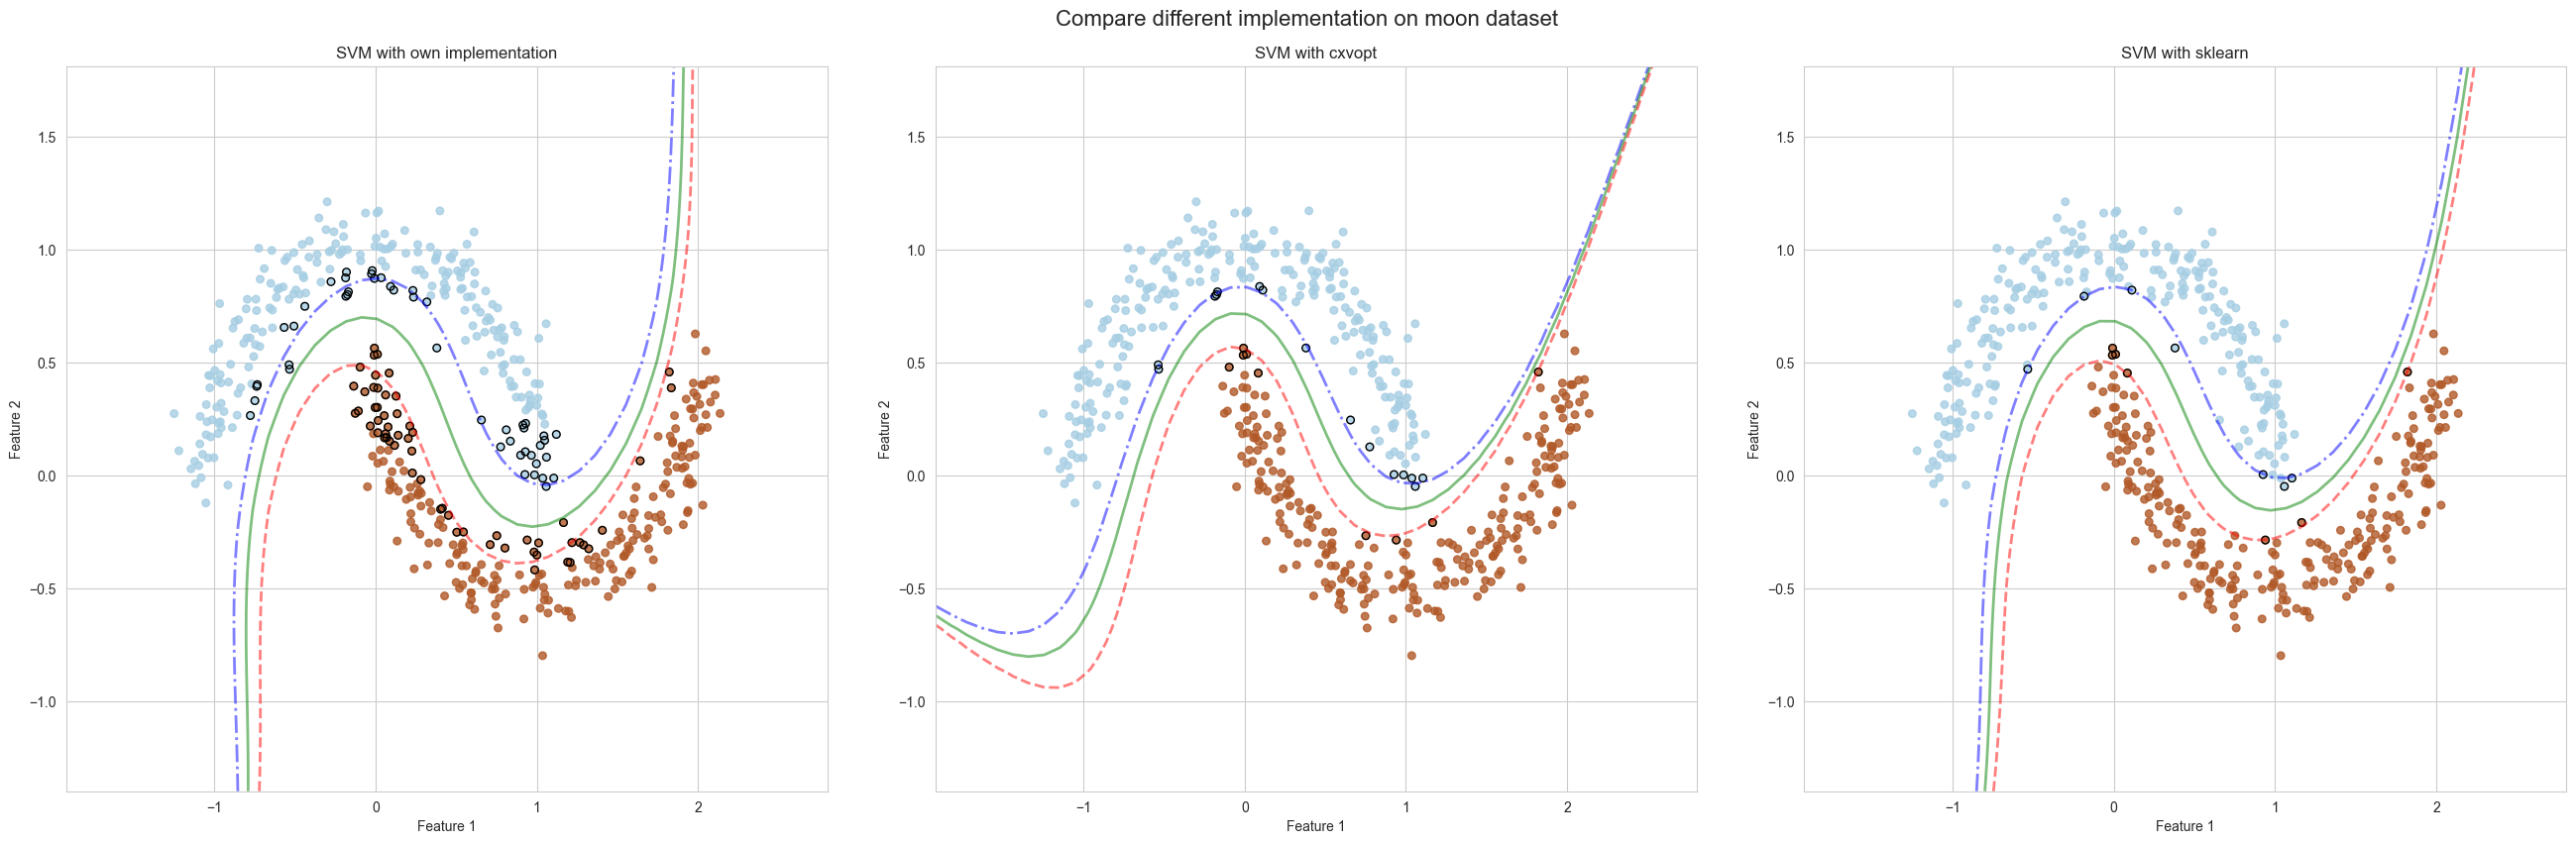

In [599]:
# Reproducibility
np.random.seed(1234)

# Moon dataset
fig, axes = plt.subplots(1, 3, figsize=(27, 9))
fig.tight_layout(pad=5.0)
fig.suptitle('Compare different implementation on moon dataset', fontsize=16)

# SVM - own implementation
SVM1 = SVM(C=5.0, kernel='poly', degree=3, coef0=1.0, epochs=3000, learning_rate=0.0001, gamma=1.0)
SVM1.fit(X_moon, y_moon)
plot_decision_boundary(X_moon, y_moon, SVM1, axis=axes[0], title='SVM with own implementation')
print(f"Accuracy of own implementation model (train set): {SVM1.score(X_moon, y_moon)}")

# SVM - using optimization libraries
SVM2 = SVM_OPT(C=5.0, kernel='poly', degree=4, coef0=1.0, optimization='cxvopt', gamma=1.0)
SVM2.fit(X_moon, y_moon)
plot_decision_boundary(X_moon, y_moon, SVM2, axis=axes[1], title='SVM with cxvopt')
print(f"Accuracy of cxvopt model (train set): {SVM2.score(X_moon, y_moon)}")

# SVM - sklearn
SVM3 = SVC(C=5.0, kernel='poly', degree=3, coef0=1.0, gamma=1.0)
SVM3.fit(X_moon, y_moon)
plot_decision_boundary(X_moon, y_moon, SVM3, axis=axes[2], title='SVM with sklearn')
print(f"Accuracy of sklearn model (train set): {SVM3.score(X_moon, y_moon)}")

plt.show()

Accuracy of own implementation model (train set): 0.988
Accuracy of scipy model (train set): 0.986
Accuracy of sklearn model (train set): 0.986


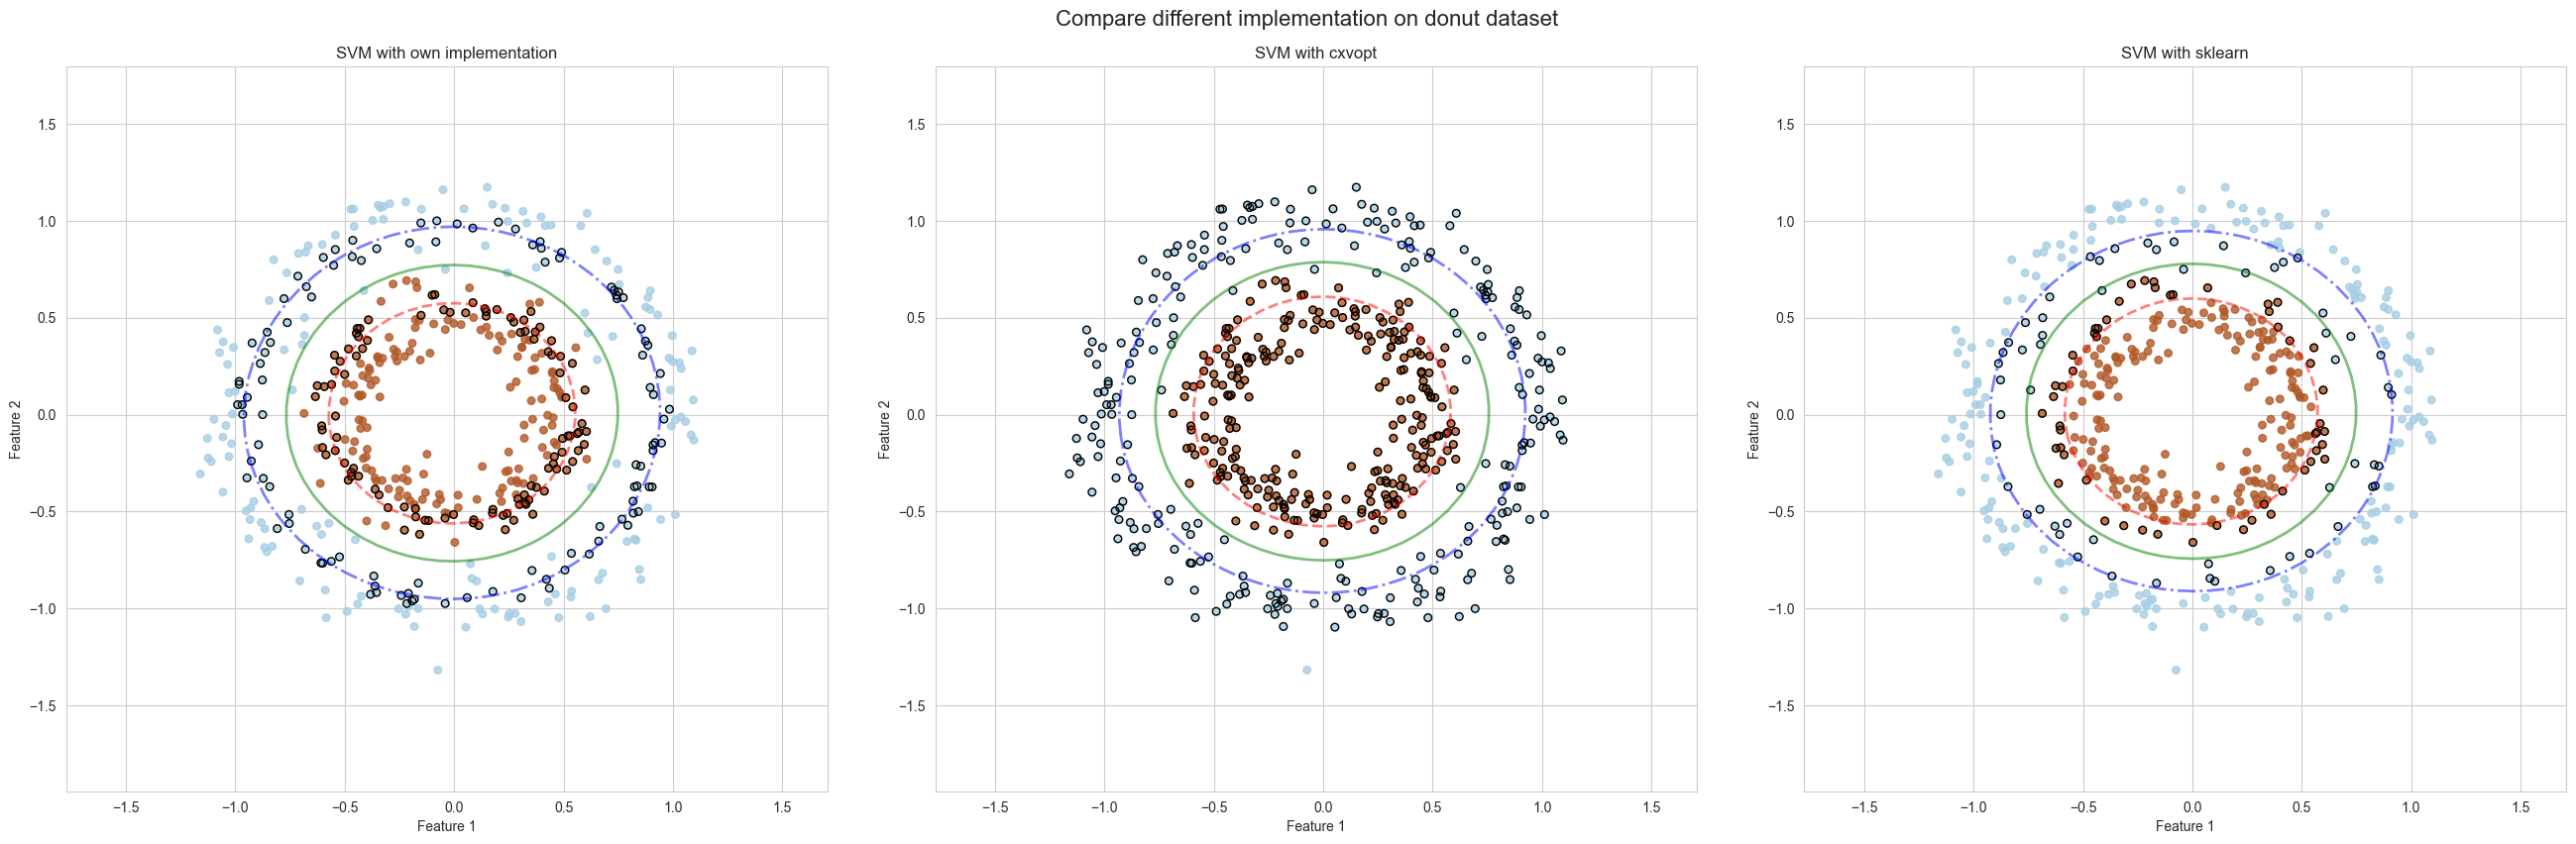

In [600]:
# Reproducibility
np.random.seed(1234)

# Donut dataset
fig, axes = plt.subplots(1, 3, figsize=(27, 9))
fig.tight_layout(pad=5.0)
fig.suptitle('Compare different implementation on donut dataset', fontsize=16)

# SVM - own implementation
SVM1 = SVM(C=1.0, kernel='rbf2', gamma='auto', epochs=1000, learning_rate=0.001)
SVM1.fit(X_donut, y_donut)
plot_decision_boundary(X_donut, y_donut, SVM1, axis=axes[0], title='SVM with own implementation')
print(f"Accuracy of own implementation model (train set): {SVM1.score(X_donut, y_donut)}")

# SVM - using optimization libraries
SVM2 = SVM_OPT(C=1.0, kernel='rbf2', gamma='auto', optimization='cxvopt')
SVM2.fit(X_donut, y_donut)
plot_decision_boundary(X_donut, y_donut, SVM2, axis=axes[1], title='SVM with cxvopt')
print(f"Accuracy of scipy model (train set): {SVM2.score(X_donut, y_donut)}")

# SVM - sklearn
SVM3 = SVC(C=1.0, kernel='rbf', gamma='auto')
SVM3.fit(X_donut, y_donut)
plot_decision_boundary(X_donut, y_donut, SVM3, axis=axes[2], title='SVM with sklearn')
print(f"Accuracy of sklearn model (train set): {SVM3.score(X_donut, y_donut)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of sklearn model (train set): 1.0


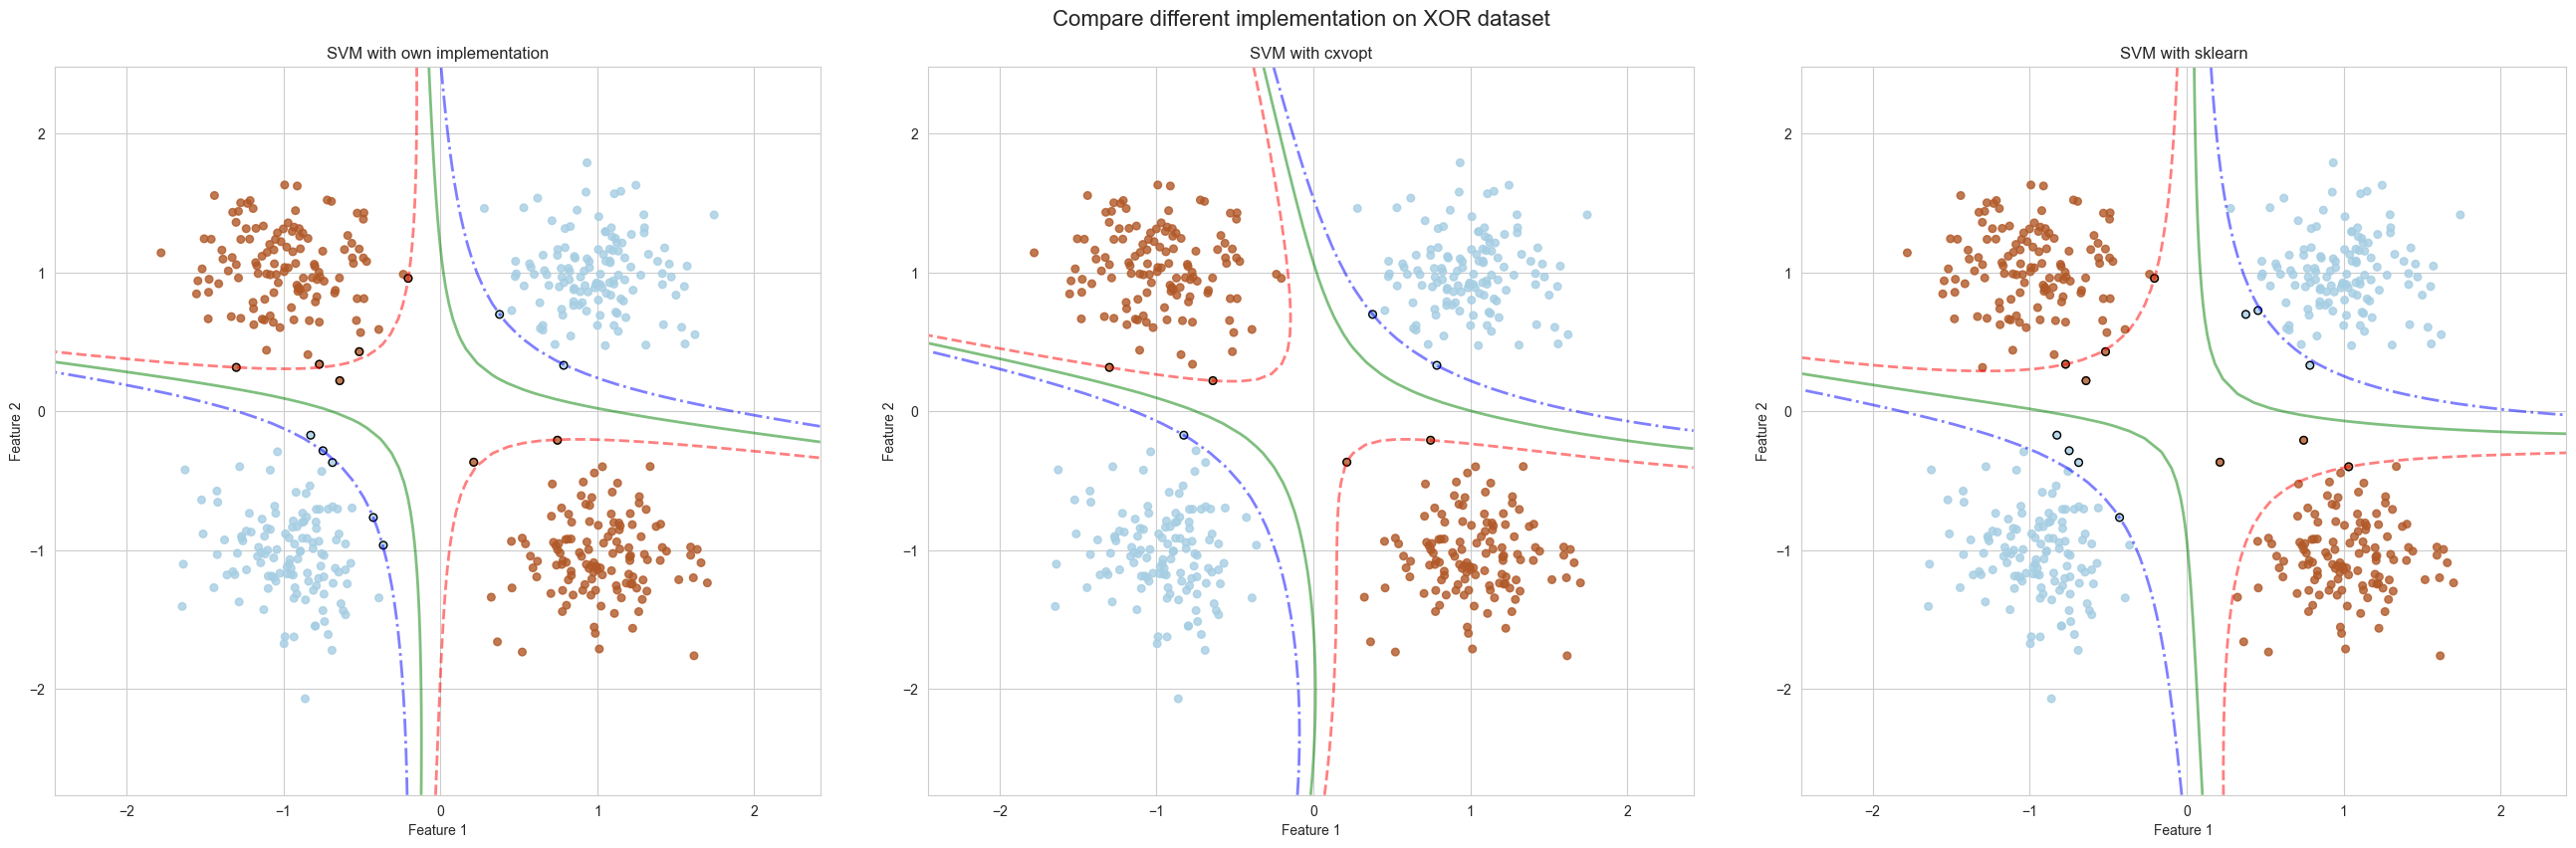

In [601]:
# Reproducibility
np.random.seed(1234)

# XOR dataset
fig, axes = plt.subplots(1, 3, figsize=(27, 9))
fig.tight_layout(pad=5.0)
fig.suptitle('Compare different implementation on XOR dataset', fontsize=16)

# SVM - own implementation
SVM1 = SVM(C=1.0, kernel='poly', degree=3, coef0=1.0, epochs=1000, learning_rate=0.001, gamma=1.0)
SVM1.fit(X_xor, y_xor)
plot_decision_boundary(X_xor, y_xor, SVM1, axis=axes[0], title='SVM with own implementation')
print(f"Accuracy of own implementation model (train set): {SVM1.score(X_xor, y_xor)}")

# SVM - using optimization libraries
SVM2 = SVM_OPT(C=5.0, kernel='poly', degree=3, coef0=1.0, optimization='cxvopt', gamma=1.0)
SVM2.fit(X_xor, y_xor)
plot_decision_boundary(X_xor, y_xor, SVM2, axis=axes[1], title='SVM with cxvopt')
print(f"Accuracy of cxvopt model (train set): {SVM2.score(X_xor, y_xor)}")

# SVM - sklearn
SVM3 = SVC(C=1.0, kernel='poly', degree=3, coef0=1.0)
SVM3.fit(X_xor, y_xor)
plot_decision_boundary(X_xor, y_xor, SVM3, axis=axes[2], title='SVM with sklearn')
print(f"Accuracy of sklearn model (train set): {SVM3.score(X_xor, y_xor)}")

#### Klasyfikacja zbioru Iris

In [368]:
# Load dataset
df_iris = pd.DataFrame(np.hstack((datasets.load_iris().data, datasets.load_iris().target.reshape(-1, 1))), columns=datasets.load_iris().feature_names + ['species'])
df_iris['species_names'] = df_iris['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_names
0,5.1,3.5,1.4,0.2,0.0,setosa
1,4.9,3.0,1.4,0.2,0.0,setosa
2,4.7,3.2,1.3,0.2,0.0,setosa
3,4.6,3.1,1.5,0.2,0.0,setosa
4,5.0,3.6,1.4,0.2,0.0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0,virginica
146,6.3,2.5,5.0,1.9,2.0,virginica
147,6.5,3.0,5.2,2.0,2.0,virginica
148,6.2,3.4,5.4,2.3,2.0,virginica


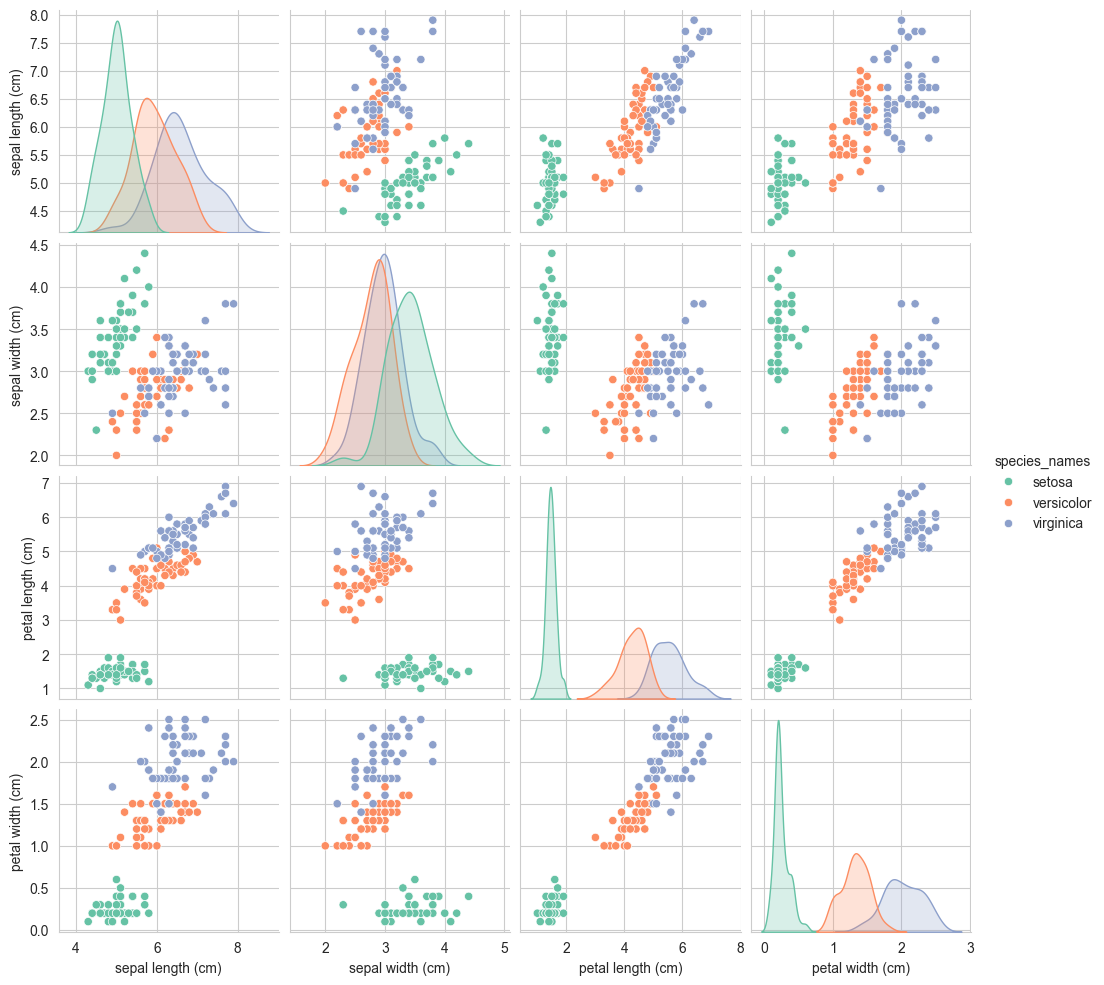

In [369]:
# Pairplot
sns.pairplot(df_iris, vars=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], hue='species_names', palette='Set2')

In [370]:
X_iris, y_iris = df_iris.iloc[:, :4].values, df_iris.iloc[:, -2].values

# Normalize features
scaler = StandardScaler()
X_iris = scaler.fit_transform(X_iris)

# Create datasets for 3 binary classification problems

# Setosa vs Non-Setosa
y_setosa = y_iris.copy()
y_setosa[y_setosa != 0] = -1
y_setosa[y_setosa == 0] = 1

# Train-test split
X_train_setosa, X_test_setosa, y_train_setosa, y_test_setosa = train_test_split(X_iris, y_setosa, test_size=0.2, random_state=1234)

# Versicolor vs Non-Versicolor
y_versicolor = y_iris.copy()
y_versicolor[y_versicolor != 1] = -1
y_versicolor[y_versicolor == 1] = 1

# Train-test split
X_train_versicolor, X_test_versicolor, y_train_versicolor, y_test_versicolor = train_test_split(X_iris, y_versicolor, test_size=0.2, random_state=1234)

# Virginica vs Non-Virginica
y_virginica = y_iris.copy()
y_virginica[y_virginica != 2] = -1
y_virginica[y_virginica == 2] = 1

# Train-test split
X_train_virginica, X_test_virginica, y_train_virginica, y_test_virginica = train_test_split(X_iris, y_virginica, test_size=0.2, random_state=1234)

##### Setosa vs Non-Setosa

In [371]:
# Own implementation with linear kernel
SVM_setosa = SVM(C=1.0, kernel='linear', learning_rate=0.001, epochs=1000)
SVM_setosa.fit(X_train_setosa, y_train_setosa)
print(f"Accuracy of own implementation model (train set): {SVM_setosa.score(X_train_setosa, y_train_setosa)}")
print(f"Accuracy of own implementation model (test set): {SVM_setosa.score(X_test_setosa, y_test_setosa)}")

# Using optimization libraries with linear kernel
SVM_setosa_opt = SVM_OPT(C=1.0, kernel='linear', optimization='cxvopt', epochs=1000)
SVM_setosa_opt.fit(X_train_setosa, y_train_setosa)
print(f"Accuracy of cxvopt model (train set): {SVM_setosa_opt.score(X_train_setosa, y_train_setosa)}")
print(f"Accuracy of cxvopt model (test set): {SVM_setosa_opt.score(X_test_setosa, y_test_setosa)}")

# Sklearn model with linear kernel
SVM_setosa_sklearn = SVC(C=0.1, kernel='linear')
SVM_setosa_sklearn.fit(X_train_setosa, y_train_setosa)
print(f"Accuracy of sklearn model (train set): {SVM_setosa_sklearn.score(X_train_setosa, y_train_setosa)}")
print(f"Accuracy of sklearn model (test set): {SVM_setosa_sklearn.score(X_test_setosa, y_test_setosa)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


##### Versicolor vs Non-Versicolor

In [372]:
# Own implementation with rbf kernel
SVM_versicolor = SVM(**{'C': 7.927392583660378, 'epochs': 100, 'gamma': 0.6, 'kernel': 'rbf', 'learning_rate': 0.0076396369297963024})
SVM_versicolor.fit(X_train_versicolor, y_train_versicolor)
print(f"Accuracy of own implementation model (train set): {SVM_versicolor.score(X_train_versicolor, y_train_versicolor)}")
print(f"Accuracy of own implementation model (test set): {SVM_versicolor.score(X_test_versicolor, y_test_versicolor)}")

# Using optimization libraries with rbf kernel
SVM_versicolor_opt = SVM_OPT(**{'C': 7.927392583660378, 'epochs': 100, 'gamma': 0.6, 'kernel': 'rbf'})
SVM_versicolor_opt.fit(X_train_versicolor, y_train_versicolor)
print(f"Accuracy of cxvopt model (train set): {SVM_versicolor_opt.score(X_train_versicolor, y_train_versicolor)}")
print(f"Accuracy of cxvopt model (test set): {SVM_versicolor_opt.score(X_test_versicolor, y_test_versicolor)}")

# Sklearn model with rbf kernel
SVM_versicolor_sklearn = SVC(**{'C': 6.015354, 'gamma': 1.8, 'kernel': 'rbf'})
SVM_versicolor_sklearn.fit(X_train_versicolor, y_train_versicolor)
print(f"Accuracy of sklearn model (train set): {SVM_versicolor_sklearn.score(X_train_versicolor, y_train_versicolor)}")
print(f"Accuracy of sklearn model (test set): {SVM_versicolor_sklearn.score(X_test_versicolor, y_test_versicolor)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


##### Virginica vs Non-Virginica

In [373]:
# Own implementation with rbf kernel
SVM_virginica = SVM(**{'C': 5.786476519176627, 'epochs': 300, 'gamma': 'auto', 'kernel': 'rbf', 'learning_rate': 0.007345808802803455})
SVM_virginica.fit(X_train_virginica, y_train_virginica)
print(f"Accuracy of own implementation model (train set): {SVM_virginica.score(X_train_virginica, y_train_virginica)}")
print(f"Accuracy of own implementation model (test set): {SVM_virginica.score(X_test_virginica, y_test_virginica)}")

# Using optimization libraries with poly kernel
SVM_virginica_opt = SVM_OPT(**{'C': 3.989474451556255, 'coef0': 0.4, 'degree': 5, 'epochs': 1000, 'kernel': 'poly', 'gamma': 1.0})
SVM_virginica_opt.fit(X_train_virginica, y_train_virginica)
print(f"Accuracy of cxvopt model (train set): {SVM_virginica_opt.score(X_train_virginica, y_train_virginica)}")
print(f"Accuracy of cxvopt model (test set): {SVM_virginica_opt.score(X_test_virginica, y_test_virginica)}")

# Sklearn model with poly kernel
SVM_virginica_sklearn = SVC(**{'C': 3.989474451556255, 'coef0': 0.4, 'degree': 5, 'kernel': 'poly', 'gamma': 1.5})
SVM_virginica_sklearn.fit(X_train_virginica, y_train_virginica)
print(f"Accuracy of sklearn model (train set): {SVM_virginica_sklearn.score(X_train_virginica, y_train_virginica)}")
print(f"Accuracy of sklearn model (test set): {SVM_virginica_sklearn.score(X_test_virginica, y_test_virginica)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


In [655]:
# Example hyperparameter tuning
best_params_svm, trials_df_svm = tune_hyperparameters(SVM, X_train_versicolor, y_train_versicolor, X_test_versicolor, y_test_versicolor, space, max_evals=20, verbose=False, dataframe=True)
trials_df_svm.sort_values(by=['test_score', 'train_score'], ascending=False)

100%|██████████| 20/20 [00:14<00:00,  1.38trial/s, best loss: -1.0]              


,C,kernel,gamma,degree,coef0,learning_rate,epochs,train_score,test_score
15,5.570721,rbf,0.2,2,2.5,0.000875,5000,1.000000,1.000000
5,1.247261,rbf,1.2,3,2.4,0.001577,400,0.975000,1.000000
11,9.629929,rbf,1.8,3,2.9,0.009067,400,0.975000,1.000000
17,3.898620,rbf,1.4,6,0.6,0.003387,3000,0.975000,1.000000
9,7.479668,linear,0.4,3,0.2,0.004435,1000,0.808333,0.733333
8,4.313934,linear,1.3,4,1.0,0.004475,500,0.800000,0.733333
10,4.953268,linear,1.4,2,0.9,0.005295,500,0.800000,0.733333
3,8.565119,linear,0.9,2,1.1,0.000570,300,0.783333,0.733333
18,0.252873,linear,1.7,6,2.8,0.000680,4000,0.741667,0.733333
7,7.620571,linear,scale,2,2.6,0.001539,3000,0.808333,0.700000


#### Wyniki klasyfikacji zbioru Iris


In [374]:
# Own implementation
OneVsAll_iris = OneVsAllSVM(classes=[0, 1, 2], classifiers=[SVM_setosa, SVM_versicolor, SVM_virginica])
predictions = OneVsAll_iris.predict(X_iris)

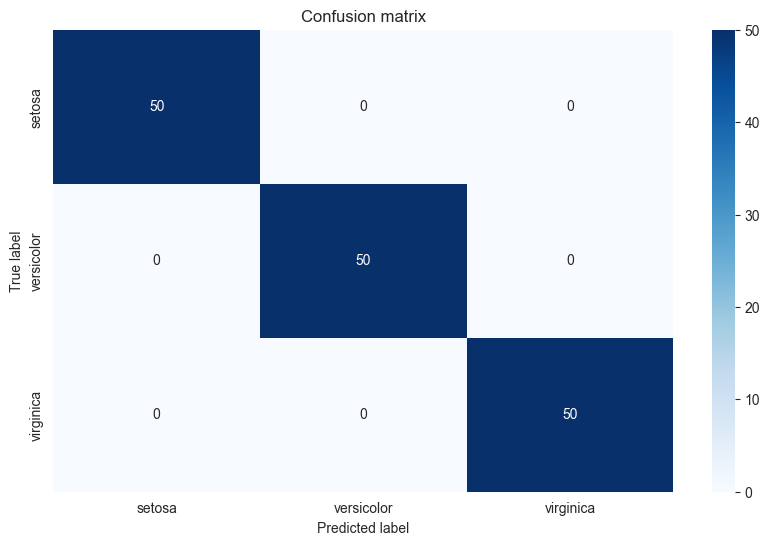

In [375]:
# Confusion matrix
conf_matrix = confusion_matrix(y_iris, predictions)
plot_confusion_matrix(conf_matrix, classes=['setosa', 'versicolor', 'virginica'])

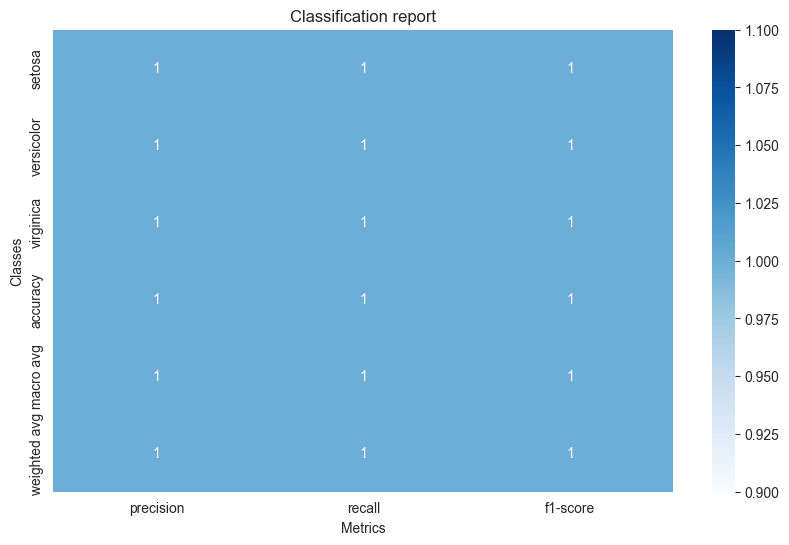

In [376]:
# Classification report
report = classification_report(y_iris, predictions, target_names=['setosa', 'versicolor', 'virginica'], output_dict=True)
plot_classification_report(report)

#### Klasyfikacja zbioru Breast Cancer

In [615]:
df_bc = pd.DataFrame(np.hstack((breast_cancer.data, breast_cancer.target.reshape(-1, 1))),
                     columns=breast_cancer.feature_names.tolist() + ['target'])
df_bc['target_names'] = df_bc['target'].map({0: 'malignant', 1: 'benign'})
df_bc

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,target_names
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0.0,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0.0,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0.0,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0.0,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0.0,malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0.0,malignant
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0.0,malignant
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0.0,malignant
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0.0,malignant


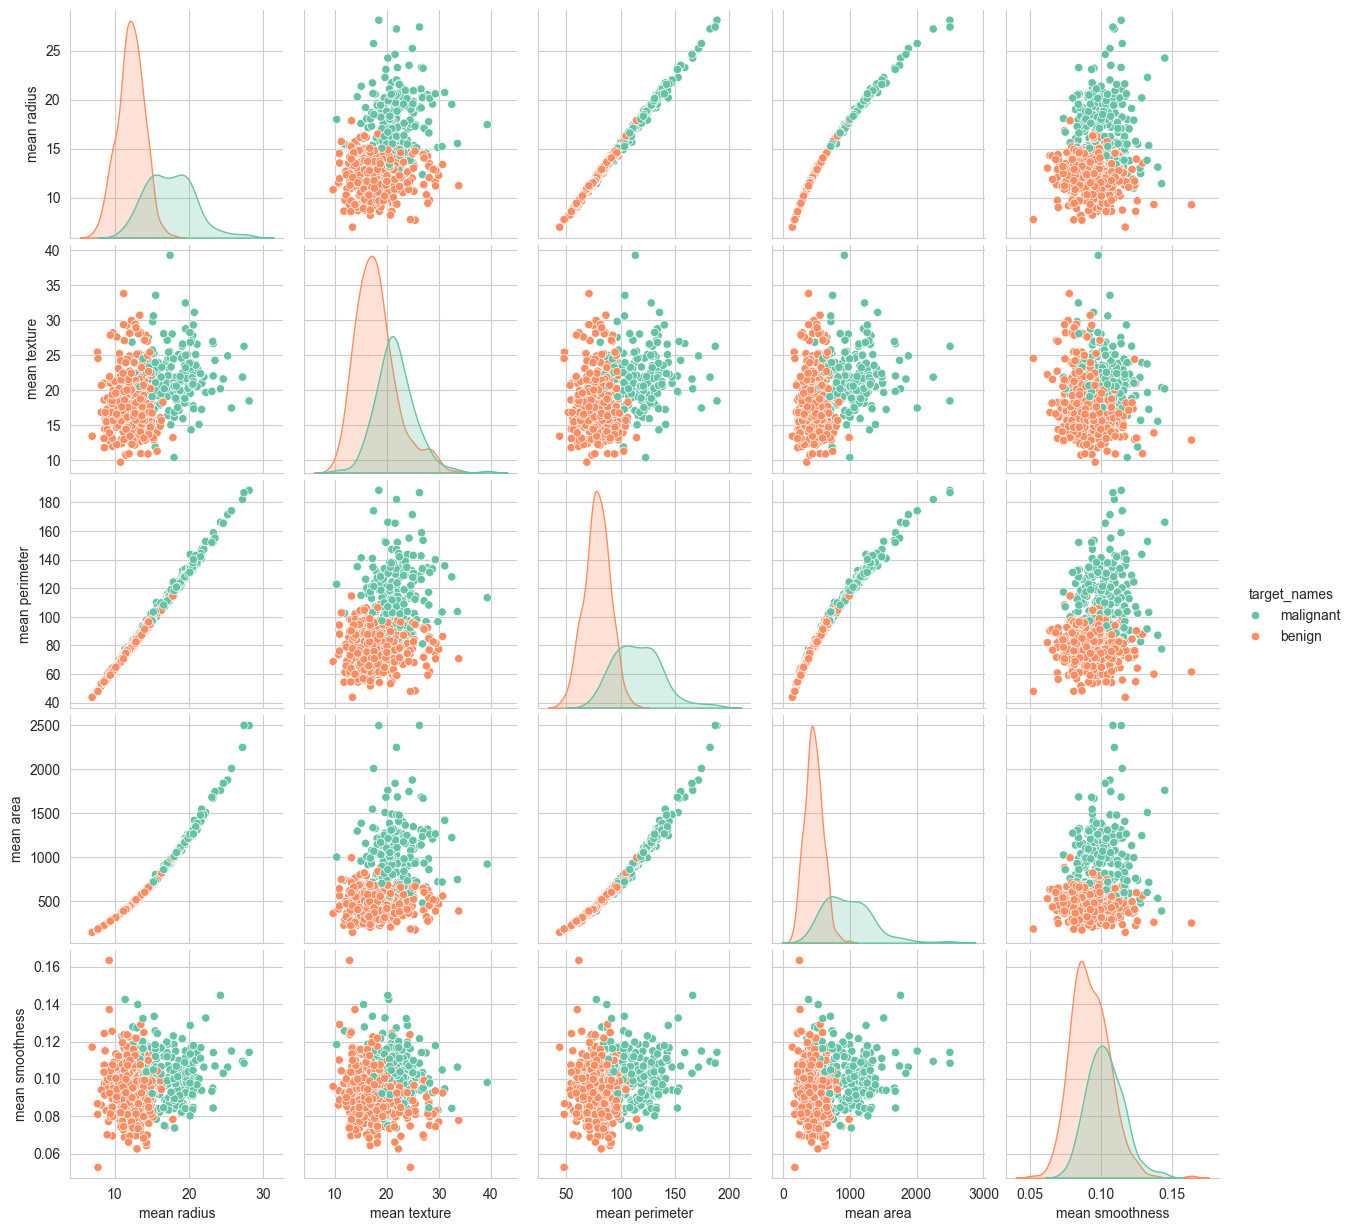

In [616]:
# Pairplot of first 5 features
sns.pairplot(df_bc, vars=breast_cancer.feature_names[:5], hue='target_names', palette='Set2')

In [646]:
X_bc, y_bc = df_bc.iloc[:, :-2].values, df_bc.iloc[:, -2].values

# Normalize features
scaler_bc = MinMaxScaler()
X_bc = scaler_bc.fit_transform(X_bc)

# Train-test split
X_train_bc, X_test_bc, y_train_bc, y_test_bc = train_test_split(X_bc, y_bc, test_size=0.2, random_state=1234)

# Malignant vs Benign
y_bc[y_bc == 0] = -1

##### Malignant vs Benign

In [653]:
# Own implementation with rbf kernel
SVM_bc = SVM(**{'C': 8.82301131163502, 'epochs': 4000, 'gamma': 0.30000000000000004, 'kernel': 'rbf', 'learning_rate': 0.009227002735838565})
SVM_bc.fit(X_train_bc, y_train_bc)
print(f"Accuracy of own implementation model (train set): {SVM_bc.score(X_train_bc, y_train_bc)}")
print(f"Accuracy of own implementation model (test set): {SVM_bc.score(X_test_bc, y_test_bc)}")

# Using optimization libraries with rbf kernel
SVM_bc_opt = SVM_OPT(**{'C': 1.4774772783337131, 'epochs': 5000, 'gamma': 1.0, 'kernel': 'rbf'})
SVM_bc_opt.fit(X_train_bc, y_train_bc)
print(f"Accuracy of cxvopt model (train set): {SVM_bc_opt.score(X_train_bc, y_train_bc)}")
print(f"Accuracy of cxvopt model (test set): {SVM_bc_opt.score(X_test_bc, y_test_bc)}")

# Sklearn model with poly kernel
SVM_bc_sklearn = SVC(**{'C': 9.205641915710459, 'coef0': 1.3, 'degree': 3, 'gamma': 0.6, 'kernel': 'poly'})
SVM_bc_sklearn.fit(X_train_bc, y_train_bc)
print(f"Accuracy of sklearn model (train set): {SVM_bc_sklearn.score(X_train_bc, y_train_bc)}")
print(f"Accuracy of sklearn model (test set): {SVM_bc_sklearn.score(X_test_bc, y_test_bc)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9649122807017544
Accuracy of cxvopt model (train set): 0.9868131868131869
Accuracy of cxvopt model (test set): 0.9649122807017544
Accuracy of sklearn model (train set): 0.9956043956043956
Accuracy of sklearn model (test set): 0.9736842105263158


In [654]:
# Example hyperparameter tuning
best_params_svm_bc, trials_df_svm_bc = tune_hyperparameters(SVM, X_train_bc, y_train_bc, X_test_bc, y_test_bc, space, max_evals=20, verbose=False, dataframe=True)
trials_df_svm_bc.sort_values(by=['test_score', 'train_score'], ascending=False)

100%|██████████| 20/20 [00:13<00:00,  1.45trial/s, best loss: -0.9649122807017544]


,C,kernel,gamma,degree,coef0,learning_rate,epochs,train_score,test_score
18,8.702759,rbf,1.1,4,1.2,0.004371,1000,0.995604,0.964912
8,2.752467,rbf,0.9,2,1.7,0.005227,3000,0.991209,0.964912
16,4.773005,rbf,0.4,4,1.4,0.002742,100,0.995604,0.938596
6,0.318187,rbf,0.9,4,0.9,0.003895,2000,0.982418,0.921053
13,5.040499,rbf,1.8,4,1.7,0.009261,3000,0.846154,0.824561
14,0.758900,rbf,1.3,4,2.6,0.009644,4000,0.837363,0.824561
11,0.918772,linear,1.7,3,2.0,0.002396,300,0.782418,0.798246
2,4.757016,linear,0.5,6,1.1,0.002657,200,0.670330,0.675439
9,0.976049,sigmoid,0.8,6,2.8,0.002944,100,0.632967,0.605263
10,1.860995,linear,0.3,6,2.9,0.003787,2000,0.406593,0.464912


#### Wyniki klasyfikacji zbioru Breast Cancer

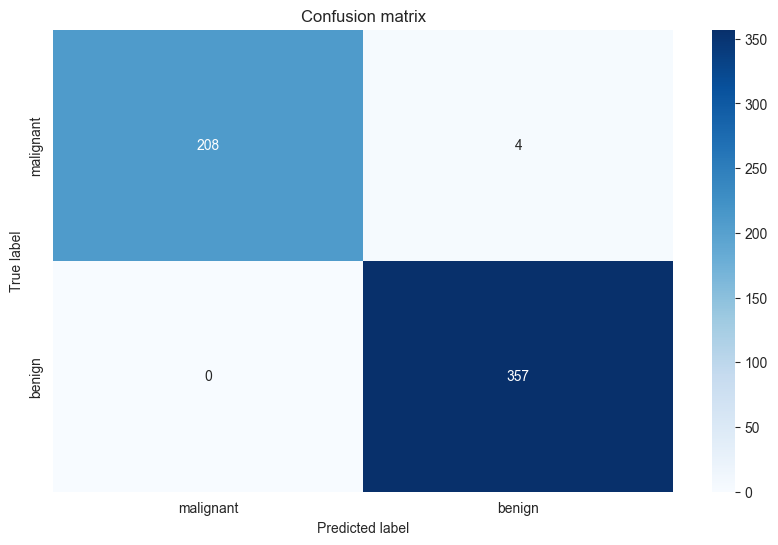

In [656]:
# Confusion matrix
predictions_bc = SVM_bc.predict(X_bc)
conf_matrix_bc = confusion_matrix(y_bc, predictions_bc)
plot_confusion_matrix(conf_matrix_bc, classes=['malignant', 'benign'])

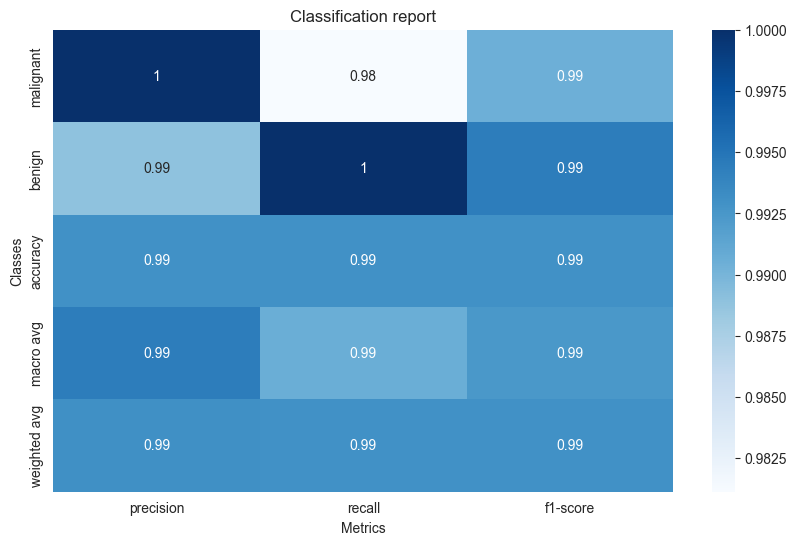

In [657]:
# Classification report
report_bc = classification_report(y_bc, predictions_bc, target_names=['malignant', 'benign'], output_dict=True)
plot_classification_report(report_bc)

#### Klasyfikacja zbioru MNIST

In [10]:
X_mnist, y_mnist = MNIST['data'].values, MNIST['target'].astype(int).values
# X_mnist, y_mnist = MNIST['data'], MNIST['target']

# Split dataset - subset 1% of the data for faster computation
X_mnist, _, y_mnist, _ = train_test_split(X_mnist, y_mnist, test_size=0.99, random_state=1234)

In [11]:
# Normalize features
scaler_mnist = MinMaxScaler()
X_mnist = scaler_mnist.fit_transform(X_mnist)

# Create datasets for 10 binary classification problems

# 0 vs Non-0
y_0 = y_mnist.copy()
y_0[y_0 != 0] = -1
y_0[y_0 == 0] = 1

# Train-test split
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_mnist, y_0, test_size=0.2, random_state=1234)

# 1 vs Non-1
y_1 = y_mnist.copy()
y_1[y_1 != 1] = -1
y_1[y_1 == 1] = 1

# Train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_mnist, y_1, test_size=0.2, random_state=1234)

# 2 vs Non-2
y_2 = y_mnist.copy()
y_2[y_2 != 2] = -1
y_2[y_2 == 2] = 1

# Train-test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_mnist, y_2, test_size=0.2, random_state=1234)

# 3 vs Non-3
y_3 = y_mnist.copy()
y_3[y_3 != 3] = -1
y_3[y_3 == 3] = 1

# Train-test split
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_mnist, y_3, test_size=0.2, random_state=1234)

# 4 vs Non-4
y_4 = y_mnist.copy()
y_4[y_4 != 4] = -1
y_4[y_4 == 4] = 1

# Train-test split
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_mnist, y_4, test_size=0.2, random_state=1234)

# 5 vs Non-5
y_5 = y_mnist.copy()
y_5[y_5 != 5] = -1
y_5[y_5 == 5] = 1

# Train-test split
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_mnist, y_5, test_size=0.2, random_state=1234)

# 6 vs Non-6
y_6 = y_mnist.copy()
y_6[y_6 != 6] = -1
y_6[y_6 == 6] = 1

# Train-test split
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_mnist, y_6, test_size=0.2, random_state=1234)

# 7 vs Non-7
y_7 = y_mnist.copy()
y_7[y_7 != 7] = -1
y_7[y_7 == 7] = 1

# Train-test split
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_mnist, y_7, test_size=0.2, random_state=1234)

# 8 vs Non-8
y_8 = y_mnist.copy()
y_8[y_8 != 8] = -1
y_8[y_8 == 8] = 1

# Train-test split
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(X_mnist, y_8, test_size=0.2, random_state=1234)

# 9 vs Non-9
y_9 = y_mnist.copy()
y_9[y_9 != 9] = -1
y_9[y_9 == 9] = 1
    
# Train-test split
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(X_mnist, y_9, test_size=0.2, random_state=1234)

##### 0 vs Non-0

In [206]:
# Own implementation with rbf kernel
SVM_0 = SVM(**{'C': 5.704260551557657, 'epochs': 3000, 'gamma': 2.0, 'kernel': 'rbf', 'learning_rate': 0.058944748388963894})
SVM_0.fit(X_train_0, y_train_0)
print(f"Accuracy of own implementation model (train set): {SVM_0.score(X_train_0, y_train_0)}")
print(f"Accuracy of own implementation model (test set): {SVM_0.score(X_test_0, y_test_0)}")

# Using optimization libraries with poly kernel
SVM_0_opt = SVM_OPT(**{'C': 0.4852249922081946, 'coef0': 0.0, 'degree': 3, 'epochs': 400, 'gamma': 1.6, 'kernel': 'poly'})
SVM_0_opt.fit(X_train_0, y_train_0)
print(f"Accuracy of cxvopt model (train set): {SVM_0_opt.score(X_train_0, y_train_0)}")
print(f"Accuracy of cxvopt model (test set): {SVM_0_opt.score(X_test_0, y_test_0)}")

# Sklearn model with poly kernel
SVM_0_sklearn = SVC(**{'C': 1.2284544377013558, 'coef0': 2.1, 'degree': 3, 'gamma': 1.2000000000000002, 'kernel': 'poly'})
SVM_0_sklearn.fit(X_train_0, y_train_0)
print(f"Accuracy of sklearn model (train set): {SVM_0_sklearn.score(X_train_0, y_train_0)}")
print(f"Accuracy of sklearn model (test set): {SVM_0_sklearn.score(X_test_0, y_test_0)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9928571428571429
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9928571428571429
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9928571428571429


##### 1 vs Non-1

In [207]:
# Own implementation with rbf kernel
SVM_1 = SVM(**{'C': 9.091377593378818, 'epochs': 100, 'gamma': 1.2000000000000002, 'kernel': 'rbf', 'learning_rate': 0.08829575889426598})
SVM_1.fit(X_train_1, y_train_1)
print(f"Accuracy of own implementation model (train set): {SVM_1.score(X_train_1, y_train_1)}")
print(f"Accuracy of own implementation model (test set): {SVM_1.score(X_test_1, y_test_1)}")

# Using optimization libraries with poly kernel
SVM_1_opt = SVM_OPT(**{'C': 1.872871897301745, 'coef0': 0.4, 'degree': 2, 'epochs': 600, 'gamma': 2.0, 'kernel': 'poly'})
SVM_1_opt.fit(X_train_1, y_train_1)
print(f"Accuracy of cxvopt model (train set): {SVM_1_opt.score(X_train_1, y_train_1)}")
print(f"Accuracy of cxvopt model (test set): {SVM_1_opt.score(X_test_1, y_test_1)}")

# Sklearn model with poly kernel
SVM_1_sklearn = SVC(**{'C': 4.370834453389086, 'coef0': 0.5, 'degree': 2, 'gamma': 2.6, 'kernel': 'poly'})
SVM_1_sklearn.fit(X_train_1, y_train_1)
print(f"Accuracy of sklearn model (train set): {SVM_1_sklearn.score(X_train_1, y_train_1)}")
print(f"Accuracy of sklearn model (test set): {SVM_1_sklearn.score(X_test_1, y_test_1)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9928571428571429
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9928571428571429


##### 2 vs Non-2

In [89]:
# Own implementation with rbf kernel
SVM_2 = SVM(**{'C': 5.0, 'epochs': 2000, 'gamma': 2.2, 'kernel': 'rbf', 'learning_rate': 0.006704473585303053})
SVM_2.fit(X_train_2, y_train_2)
print(f"Accuracy of own implementation model (train set): {SVM_2.score(X_train_2, y_train_2)}")
print(f"Accuracy of own implementation model (test set): {SVM_2.score(X_test_2, y_test_2)}")

# Using optimization libraries with poly kernel
SVM_2_opt = SVM_OPT(**{'C': 8.21831710387888, 'coef0': 1.9000000000000001, 'degree': 2, 'epochs': 2000, 'gamma': 3.3000000000000003, 'kernel': 'poly'})
SVM_2_opt.fit(X_train_2, y_train_2)
print(f"Accuracy of cxvopt model (train set): {SVM_2_opt.score(X_train_2, y_train_2)}")
print(f"Accuracy of cxvopt model (test set): {SVM_2_opt.score(X_test_2, y_test_2)}")

# Sklearn model with poly kernel
SVM_2_sklearn = SVC(**{'C': 4.359678810276566, 'coef0': 3.8000000000000003, 'degree': 6, 'gamma': 'scale', 'kernel': 'poly'})
SVM_2_sklearn.fit(X_train_2, y_train_2)
print(f"Accuracy of sklearn model (train set): {SVM_2_sklearn.score(X_train_2, y_train_2)}")
print(f"Accuracy of sklearn model (test set): {SVM_2_sklearn.score(X_test_2, y_test_2)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9785714285714285
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9642857142857143
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9714285714285714


##### 3 vs Non-3

In [98]:
# Own implementation with rbf kernel
SVM_3 = SVM(**{'C': 5.966962567635972, 'epochs': 1000, 'gamma': 3.1, 'kernel': 'rbf', 'learning_rate': 0.08591673899282391})
SVM_3.fit(X_train_3, y_train_3)
print(f"Accuracy of own implementation model (train set): {SVM_3.score(X_train_3, y_train_3)}")
print(f"Accuracy of own implementation model (test set): {SVM_3.score(X_test_3, y_test_3)}")

# Using optimization libraries with poly kernel
SVM_3_opt = SVM_OPT(**{'C': 6.123132, 'coef0': 2.4, 'degree': 2, 'epochs': 500, 'gamma': 2.0, 'kernel': 'poly'})
SVM_3_opt.fit(X_train_3, y_train_3)
print(f"Accuracy of cxvopt model (train set): {SVM_3_opt.score(X_train_3, y_train_3)}")
print(f"Accuracy of cxvopt model (test set): {SVM_3_opt.score(X_test_3, y_test_3)}")

# Sklearn model with poly kernel
SVM_3_sklearn = SVC(**{'C': 4.016612343013385, 'coef0': 3.7, 'degree': 2, 'gamma': 0.6, 'kernel': 'poly'})
SVM_3_sklearn.fit(X_train_3, y_train_3)
print(f"Accuracy of sklearn model (train set): {SVM_3_sklearn.score(X_train_3, y_train_3)}")
print(f"Accuracy of sklearn model (test set): {SVM_3_sklearn.score(X_test_3, y_test_3)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9714285714285714
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9714285714285714
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9714285714285714


##### 4 vs Non-4

In [107]:
# Own implementation with rbf kernel
SVM_4 = SVM(**{'C': 5.039293781352707, 'epochs': 900, 'gamma': 2.1, 'kernel': 'rbf', 'learning_rate': 0.07853639919516933})
SVM_4.fit(X_train_4, y_train_4)
print(f"Accuracy of own implementation model (train set): {SVM_4.score(X_train_4, y_train_4)}")
print(f"Accuracy of own implementation model (test set): {SVM_4.score(X_test_4, y_test_4)}")

# Using optimization libraries with poly kernel
SVM_4_opt = SVM_OPT(**{'C': 6.020450533198628, 'coef0': 0.1, 'degree': 3, 'epochs': 300, 'gamma': 0.1, 'kernel': 'poly'})
SVM_4_opt.fit(X_train_4, y_train_4)
print(f"Accuracy of cxvopt model (train set): {SVM_4_opt.score(X_train_4, y_train_4)}")
print(f"Accuracy of cxvopt model (test set): {SVM_4_opt.score(X_test_4, y_test_4)}")

# Sklearn model with poly kernel
SVM_4_sklearn = SVC(**{'C': 7.402398311111021, 'coef0': 4.1000000000000005, 'degree': 2, 'gamma': 0.30000000000000004, 'kernel': 'poly'})
SVM_4_sklearn.fit(X_train_4, y_train_4)
print(f"Accuracy of sklearn model (train set): {SVM_4_sklearn.score(X_train_4, y_train_4)}")
print(f"Accuracy of sklearn model (test set): {SVM_4_sklearn.score(X_test_4, y_test_4)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9785714285714285
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9857142857142858
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9857142857142858


##### 5 vs Non-5

In [201]:
# Own implementation with rbf kernel
SVM_5 = SVM(**{'C': 2.7225057224813645, 'epochs': 5000, 'gamma': 2.8000000000000003, 'kernel': 'rbf', 'learning_rate': 0.09130088571825264})
SVM_5.fit(X_train_5, y_train_5)
print(f"Accuracy of own implementation model (train set): {SVM_5.score(X_train_5, y_train_5)}")
print(f"Accuracy of own implementation model (test set): {SVM_5.score(X_test_5, y_test_5)}")

# Using optimization libraries with poly kernel
SVM_5_opt = SVM_OPT(**{'C': 2.6616385714770456, 'coef0': 4.5, 'degree': 2, 'epochs': 500, 'gamma': 0.9, 'kernel': 'poly'})
SVM_5_opt.fit(X_train_5, y_train_5)
print(f"Accuracy of cxvopt model (train set): {SVM_5_opt.score(X_train_5, y_train_5)}")
print(f"Accuracy of cxvopt model (test set): {SVM_5_opt.score(X_test_5, y_test_5)}")

# Sklearn model with poly kernel
SVM_5_sklearn = SVC(**{'C': 3.7142863340104193, 'gamma': 'scale', 'kernel': 'rbf'})
SVM_5_sklearn.fit(X_train_5, y_train_5)
print(f"Accuracy of sklearn model (train set): {SVM_5_sklearn.score(X_train_5, y_train_5)}")
print(f"Accuracy of sklearn model (test set): {SVM_5_sklearn.score(X_test_5, y_test_5)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.95
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9428571428571428
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.95


##### 6 vs Non-6

In [156]:
# Own implementation with rbf kernel
SVM_6 = SVM(**{'C': 5.620714075798724, 'epochs': 600, 'gamma': 3.4000000000000004, 'kernel': 'rbf', 'learning_rate': 0.06198124383230356})
SVM_6.fit(X_train_6, y_train_6)
print(f"Accuracy of own implementation model (train set): {SVM_6.score(X_train_6, y_train_6)}")
print(f"Accuracy of own implementation model (test set): {SVM_6.score(X_test_6, y_test_6)}")

# Using optimization libraries with poly kernel
SVM_6_opt = SVM_OPT(**{'C': 7.195191174519655, 'coef0': 1.8, 'degree': 2, 'epochs': 600, 'gamma': 4.1, 'kernel': 'poly'})
SVM_6_opt.fit(X_train_6, y_train_6)
print(f"Accuracy of cxvopt model (train set): {SVM_6_opt.score(X_train_6, y_train_6)}")
print(f"Accuracy of cxvopt model (test set): {SVM_6_opt.score(X_test_6, y_test_6)}")

# Sklearn model with poly kernel
SVM_6_sklearn = SVC(**{'C': 3.9781918464260353, 'coef0': 4.1000000000000005, 'degree': 2, 'gamma': 1.4000000000000001, 'kernel': 'poly'})
SVM_6_sklearn.fit(X_train_6, y_train_6)
print(f"Accuracy of sklearn model (train set): {SVM_6_sklearn.score(X_train_6, y_train_6)}")
print(f"Accuracy of sklearn model (test set): {SVM_6_sklearn.score(X_test_6, y_test_6)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9928571428571429
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9714285714285714
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9714285714285714


##### 7 vs Non-7

In [166]:
# Own implementation with rbf kernel
SVM_7 = SVM(**{'C': 6.934409888935786, 'epochs': 900, 'gamma': 2.0, 'kernel': 'rbf', 'learning_rate': 0.08522334619723629})
SVM_7.fit(X_train_7, y_train_7)
print(f"Accuracy of own implementation model (train set): {SVM_7.score(X_train_7, y_train_7)}")
print(f"Accuracy of own implementation model (test set): {SVM_7.score(X_test_7, y_test_7)}")

# Using optimization libraries with linear kernel
SVM_7_opt = SVM_OPT(**{'C': 0.4860242126482194, 'epochs': 50, 'kernel': 'linear'})
SVM_7_opt.fit(X_train_7, y_train_7)
print(f"Accuracy of cxvopt model (train set): {SVM_7_opt.score(X_train_7, y_train_7)}")
print(f"Accuracy of cxvopt model (test set): {SVM_7_opt.score(X_test_7, y_test_7)}")

# Sklearn model with linear kernel
SVM_7_sklearn = SVC(**{'C': 1.0750311489241888, 'kernel': 'linear'})
SVM_7_sklearn.fit(X_train_7, y_train_7)
print(f"Accuracy of sklearn model (train set): {SVM_7_sklearn.score(X_train_7, y_train_7)}")
print(f"Accuracy of sklearn model (test set): {SVM_7_sklearn.score(X_test_7, y_test_7)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9714285714285714
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9714285714285714
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9714285714285714


##### 8 vs Non-8

In [167]:
# Own implementation with rbf kernel
SVM_8 = SVM(**{'C': 5.0, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'rbf', 'learning_rate': 0.1})
SVM_8.fit(X_train_8, y_train_8)
print(f"Accuracy of own implementation model (train set): {SVM_8.score(X_train_8, y_train_8)}")
print(f"Accuracy of own implementation model (test set): {SVM_8.score(X_test_8, y_test_8)}")

# Using optimization libraries with poly kernel
SVM_8_opt = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_8_opt.fit(X_train_8, y_train_8)
print(f"Accuracy of cxvopt model (train set): {SVM_8_opt.score(X_train_8, y_train_8)}")
print(f"Accuracy of cxvopt model (test set): {SVM_8_opt.score(X_test_8, y_test_8)}")

# Sklearn model with poly kernel
SVM_8_sklearn = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_8_sklearn.fit(X_train_8, y_train_8)
print(f"Accuracy of sklearn model (train set): {SVM_8_sklearn.score(X_train_8, y_train_8)}")
print(f"Accuracy of sklearn model (test set): {SVM_8_sklearn.score(X_test_8, y_test_8)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


##### 9 vs Non-9

In [180]:
# Own implementation with rbf kernel
SVM_9 = SVM(**{'C': 7.294703060278964, 'coef0': 2.1, 'degree': 2, 'epochs': 1000, 'gamma': 3.2, 'kernel': 'rbf', 'learning_rate': 0.05505409328179471})
SVM_9.fit(X_train_9, y_train_9)
print(f"Accuracy of own implementation model (train set): {SVM_9.score(X_train_9, y_train_9)}")
print(f"Accuracy of own implementation model (test set): {SVM_9.score(X_test_9, y_test_9)}")

# Using optimization libraries with linear kernel
SVM_9_opt = SVM_OPT(**{'C': 1.3450654955441803, 'coef0': 3.1, 'degree': 2, 'epochs': 2000, 'gamma': 2.7, 'kernel': 'poly'})
SVM_9_opt.fit(X_train_9, y_train_9)
print(f"Accuracy of cxvopt model (train set): {SVM_9_opt.score(X_train_9, y_train_9)}")
print(f"Accuracy of cxvopt model (test set): {SVM_9_opt.score(X_test_9, y_test_9)}")

# Sklearn model with poly kernel
SVM_9_sklearn = SVC(**{'C': 5.243951599594053, 'coef0': 4.800000000000001, 'degree': 2, 'gamma': 3.9000000000000004, 'kernel': 'poly'})
SVM_9_sklearn.fit(X_train_9, y_train_9)
print(f"Accuracy of sklearn model (train set): {SVM_9_sklearn.score(X_train_9, y_train_9)}")
print(f"Accuracy of sklearn model (test set): {SVM_9_sklearn.score(X_test_9, y_test_9)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9642857142857143
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9714285714285714
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9714285714285714


#### Wyniki klasyfikacji zbioru MNIST

In [209]:
# Own implementation
OneVsAll_mnist_svm = OneVsAllSVM(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], classifiers=[SVM_0, SVM_1, SVM_2, SVM_3, SVM_4, SVM_5, SVM_6, SVM_7, SVM_8, SVM_9])
predictions_mnist_svm = OneVsAll_mnist_svm.predict(X_mnist)

# Using optimization libraries
OneVsAll_mnist_svm_opt = OneVsAllSVM(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], classifiers=[SVM_0_opt, SVM_1_opt, SVM_2_opt, SVM_3_opt, SVM_4_opt, SVM_5_opt, SVM_6_opt, SVM_7_opt, SVM_8_opt, SVM_9_opt])
predictions_mnist_svm_opt = OneVsAll_mnist_svm_opt.predict(X_mnist)

# Sklearn model
OneVsAll_mnist_svm_sklearn = OneVsAllSVM(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], classifiers=[SVM_0_sklearn, SVM_1_sklearn, SVM_2_sklearn, SVM_3_sklearn, SVM_4_sklearn, SVM_5_sklearn, SVM_6_sklearn, SVM_7_sklearn, SVM_8_sklearn, SVM_9_sklearn])
predictions_mnist_svm_sklearn = OneVsAll_mnist_svm_sklearn.predict(X_mnist)

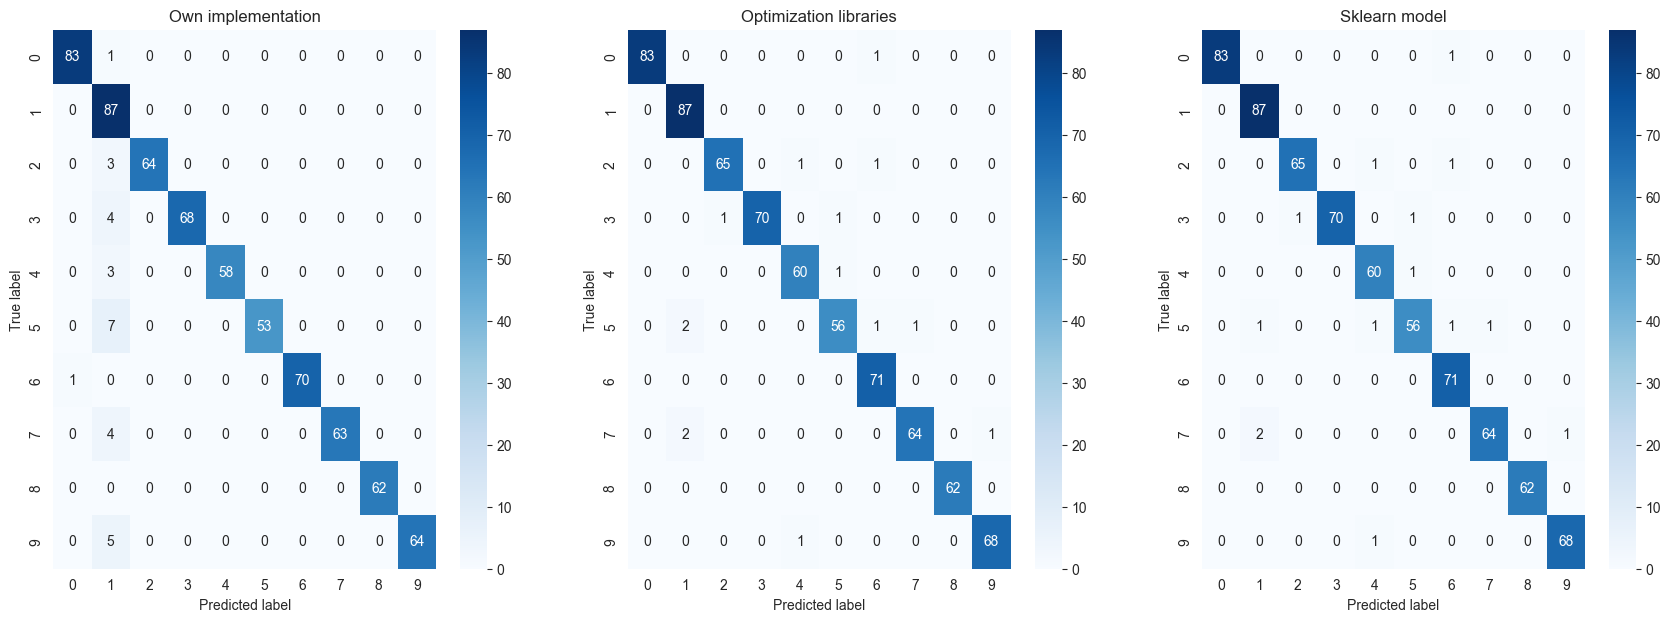

In [210]:
# Confusion matrix comparison
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
conf_matrix_mnist_svm = confusion_matrix(y_mnist, predictions_mnist_svm)
plot_confusion_matrix(conf_matrix_mnist_svm, classes=[str(i) for i in range(10)], axis=axs[0], title='Own implementation')

# Using optimization libraries
conf_matrix_mnist_svm_opt = confusion_matrix(y_mnist, predictions_mnist_svm_opt)
plot_confusion_matrix(conf_matrix_mnist_svm_opt, classes=[str(i) for i in range(10)], axis=axs[1], title='Optimization libraries')

# Sklearn model
conf_matrix_mnist_svm_sklearn = confusion_matrix(y_mnist, predictions_mnist_svm_sklearn)
plot_confusion_matrix(conf_matrix_mnist_svm_sklearn, classes=[str(i) for i in range(10)], axis=axs[2], title='Sklearn model')
                      
plt.show()

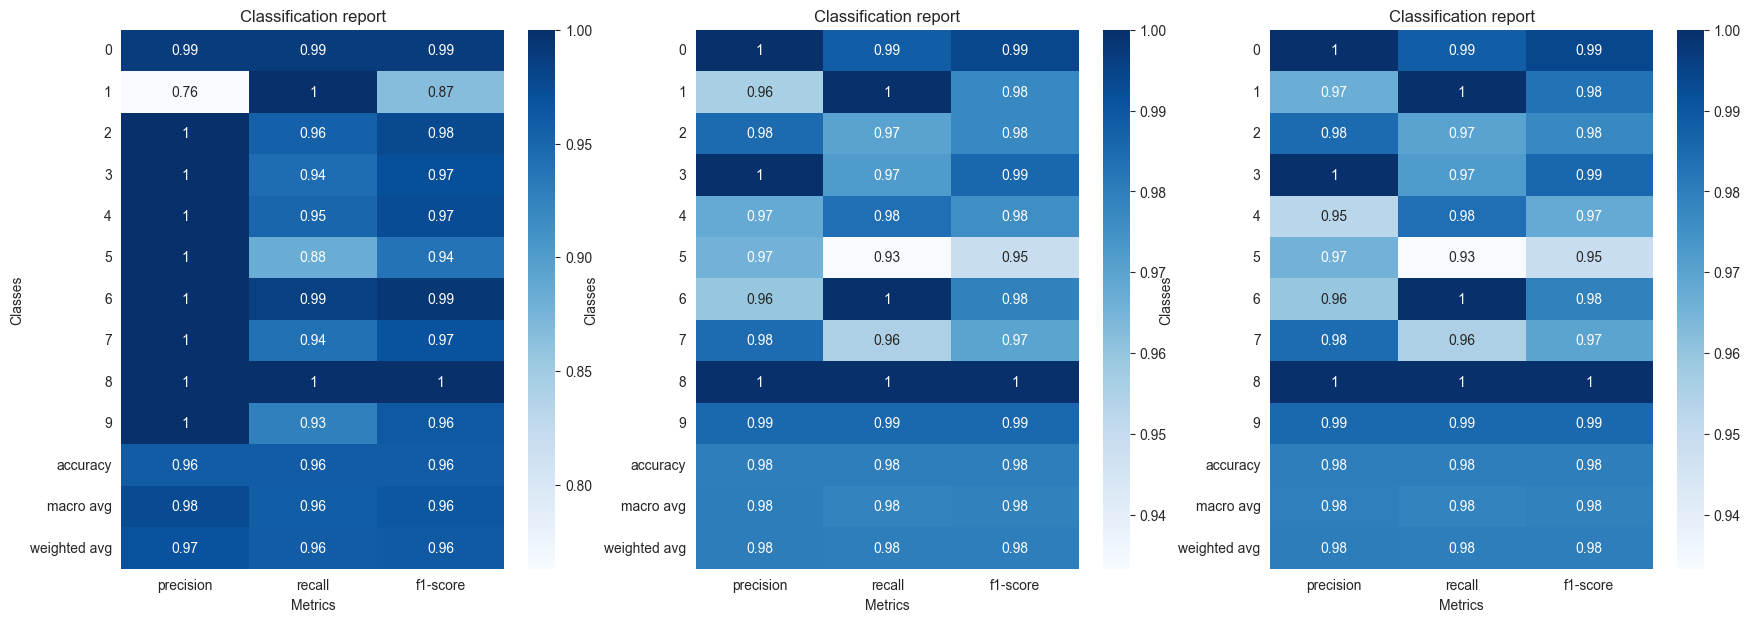

In [211]:
# Classification report
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
report_mnist_svm = classification_report(y_mnist, predictions_mnist_svm, target_names=[str(i) for i in range(10)], output_dict=True)
plot_classification_report(report_mnist_svm, axis=axs[0], title='Own implementation')

# Using optimization libraries
report_mnist_svm_opt = classification_report(y_mnist, predictions_mnist_svm_opt, target_names=[str(i) for i in range(10)], output_dict=True)
plot_classification_report(report_mnist_svm_opt, axis=axs[1], title='Optimization libraries')

# Sklearn model
report_mnist_svm_sklearn = classification_report(y_mnist, predictions_mnist_svm_sklearn, target_names=[str(i) for i in range(10)], output_dict=True)
plot_classification_report(report_mnist_svm_sklearn, axis=axs[2], title='Sklearn model')

plt.show()

#### Klasyfikacja zbioru digits

In [218]:
X_digits, y_digits = digits.data, digits.target

In [219]:
# Normalize features
scaler_digits = MinMaxScaler()
X_digits = scaler_digits.fit_transform(X_digits)

# Create datasets for 10 binary classification problems

# 0 vs Non-0
y_0_digits = y_digits.copy()
y_0_digits[y_0_digits != 0] = -1
y_0_digits[y_0_digits == 0] = 1

# Train-test split
X_train_0_digits, X_test_0_digits, y_train_0_digits, y_test_0_digits = train_test_split(X_digits, y_0_digits, test_size=0.2, random_state=1234)

# 1 vs Non-1
y_1_digits = y_digits.copy()
y_1_digits[y_1_digits != 1] = -1
y_1_digits[y_1_digits == 1] = 1

# Train-test split
X_train_1_digits, X_test_1_digits, y_train_1_digits, y_test_1_digits = train_test_split(X_digits, y_1_digits, test_size=0.2, random_state=1234)

# 2 vs Non-2
y_2_digits = y_digits.copy()
y_2_digits[y_2_digits != 2] = -1
y_2_digits[y_2_digits == 2] = 1

# Train-test split
X_train_2_digits, X_test_2_digits, y_train_2_digits, y_test_2_digits = train_test_split(X_digits, y_2_digits, test_size=0.2, random_state=1234)

# 3 vs Non-3
y_3_digits = y_digits.copy()
y_3_digits[y_3_digits != 3] = -1
y_3_digits[y_3_digits == 3] = 1

# Train-test split
X_train_3_digits, X_test_3_digits, y_train_3_digits, y_test_3_digits = train_test_split(X_digits, y_3_digits, test_size=0.2, random_state=1234)

# 4 vs Non-4
y_4_digits = y_digits.copy()
y_4_digits[y_4_digits != 4] = -1
y_4_digits[y_4_digits == 4] = 1

# Train-test split
X_train_4_digits, X_test_4_digits, y_train_4_digits, y_test_4_digits = train_test_split(X_digits, y_4_digits, test_size=0.2, random_state=1234)

# 5 vs Non-5
y_5_digits = y_digits.copy()
y_5_digits[y_5_digits != 5] = -1
y_5_digits[y_5_digits == 5] = 1

# Train-test split
X_train_5_digits, X_test_5_digits, y_train_5_digits, y_test_5_digits = train_test_split(X_digits, y_5_digits, test_size=0.2, random_state=1234)

# 6 vs Non-6
y_6_digits = y_digits.copy()
y_6_digits[y_6_digits != 6] = -1
y_6_digits[y_6_digits == 6] = 1

# Train-test split
X_train_6_digits, X_test_6_digits, y_train_6_digits, y_test_6_digits = train_test_split(X_digits, y_6_digits, test_size=0.2, random_state=1234)

# 7 vs Non-7
y_7_digits = y_digits.copy()
y_7_digits[y_7_digits != 7] = -1
y_7_digits[y_7_digits == 7] = 1

# Train-test split
X_train_7_digits, X_test_7_digits, y_train_7_digits, y_test_7_digits = train_test_split(X_digits, y_7_digits, test_size=0.2, random_state=1234)

# 8 vs Non-8
y_8_digits = y_digits.copy()
y_8_digits[y_8_digits != 8] = -1
y_8_digits[y_8_digits == 8] = 1

# Train-test split
X_train_8_digits, X_test_8_digits, y_train_8_digits, y_test_8_digits = train_test_split(X_digits, y_8_digits, test_size=0.2, random_state=1234)

# 9 vs Non-9
y_9_digits = y_digits.copy()
y_9_digits[y_9_digits != 9] = -1
y_9_digits[y_9_digits == 9] = 1

# Train-test split
X_train_9_digits, X_test_9_digits, y_train_9_digits, y_test_9_digits = train_test_split(X_digits, y_9_digits, test_size=0.2, random_state=1234)

##### 0 vs Non-0

In [222]:
# Own implementation with rbf kernel
SVM_0_digits = SVM(**{'C': 9.787124024506248, 'epochs': 200, 'gamma': 0.7000000000000001, 'kernel': 'rbf', 'learning_rate': 0.0493210996513493})
SVM_0_digits.fit(X_train_0_digits, y_train_0_digits)
print(f"Accuracy of own implementation model (train set): {SVM_0_digits.score(X_train_0_digits, y_train_0_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_0_digits.score(X_test_0_digits, y_test_0_digits)}")

# Using optimization libraries with poly kernel
SVM_0_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_0_opt_digits.fit(X_train_0_digits, y_train_0_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_0_opt_digits.score(X_train_0_digits, y_train_0_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_0_opt_digits.score(X_test_0_digits, y_test_0_digits)}")

# Sklearn model with poly kernel
SVM_0_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_0_sklearn_digits.fit(X_train_0_digits, y_train_0_digits)
print(f"Accuracy of sklearn model (train set): {SVM_0_sklearn_digits.score(X_train_0_digits, y_train_0_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_0_sklearn_digits.score(X_test_0_digits, y_test_0_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


##### 1 vs Non-1

In [226]:
# Own implementation with rbf kernel
SVM_1_digits = SVM(**{'C': 2.1260934430033727, 'epochs': 600, 'gamma': 1.1, 'kernel': 'rbf', 'learning_rate': 0.03244303441057274})
SVM_1_digits.fit(X_train_1_digits, y_train_1_digits)
print(f"Accuracy of own implementation model (train set): {SVM_1_digits.score(X_train_1_digits, y_train_1_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_1_digits.score(X_test_1_digits, y_test_1_digits)}")

# Using optimization libraries with poly kernel
SVM_1_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_1_opt_digits.fit(X_train_1_digits, y_train_1_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_1_opt_digits.score(X_train_1_digits, y_train_1_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_1_opt_digits.score(X_test_1_digits, y_test_1_digits)}")

# Sklearn model with poly kernel
SVM_1_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_1_sklearn_digits.fit(X_train_1_digits, y_train_1_digits)
print(f"Accuracy of sklearn model (train set): {SVM_1_sklearn_digits.score(X_train_1_digits, y_train_1_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_1_sklearn_digits.score(X_test_1_digits, y_test_1_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9972222222222222
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9972222222222222


##### 2 vs Non-2

In [232]:
# Own implementation with rbf kernel
SVM_2_digits = SVM(**{'C': 7.440930841344457, 'epochs': 700, 'gamma': 3.6, 'kernel': 'rbf', 'learning_rate': 0.0022170894887295726})
SVM_2_digits.fit(X_train_2_digits, y_train_2_digits)
print(f"Accuracy of own implementation model (train set): {SVM_2_digits.score(X_train_2_digits, y_train_2_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_2_digits.score(X_test_2_digits, y_test_2_digits)}")

# Using optimization libraries with poly kernel
SVM_2_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_2_opt_digits.fit(X_train_2_digits, y_train_2_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_2_opt_digits.score(X_train_2_digits, y_train_2_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_2_opt_digits.score(X_test_2_digits, y_test_2_digits)}")

# Sklearn model with poly kernel
SVM_2_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_2_sklearn_digits.fit(X_train_2_digits, y_train_2_digits)
print(f"Accuracy of sklearn model (train set): {SVM_2_sklearn_digits.score(X_train_2_digits, y_train_2_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_2_sklearn_digits.score(X_test_2_digits, y_test_2_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


##### 3 vs Non-3

In [235]:
# Own implementation with rbf kernel
SVM_3_digits = SVM(**{'C': 0.8521879853083535, 'epochs': 900, 'gamma': 0.6, 'kernel': 'rbf', 'learning_rate': 0.028743598932356302})
SVM_3_digits.fit(X_train_3_digits, y_train_3_digits)
print(f"Accuracy of own implementation model (train set): {SVM_3_digits.score(X_train_3_digits, y_train_3_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_3_digits.score(X_test_3_digits, y_test_3_digits)}")

# Using optimization libraries with poly kernel
SVM_3_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_3_opt_digits.fit(X_train_3_digits, y_train_3_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_3_opt_digits.score(X_train_3_digits, y_train_3_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_3_opt_digits.score(X_test_3_digits, y_test_3_digits)}")

# Sklearn model with poly kernel
SVM_3_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_3_sklearn_digits.fit(X_train_3_digits, y_train_3_digits)
print(f"Accuracy of sklearn model (train set): {SVM_3_sklearn_digits.score(X_train_3_digits, y_train_3_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_3_sklearn_digits.score(X_test_3_digits, y_test_3_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9972222222222222
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9972222222222222
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9972222222222222


##### 4 vs Non-4

In [237]:
# Own implementation with rbf kernel
SVM_4_digits = SVM(**{'C': 6.015991126852659, 'epochs': 3000, 'gamma': 0.9, 'kernel': 'rbf', 'learning_rate': 0.08922605333301624})
SVM_4_digits.fit(X_train_4_digits, y_train_4_digits)
print(f"Accuracy of own implementation model (train set): {SVM_4_digits.score(X_train_4_digits, y_train_4_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_4_digits.score(X_test_4_digits, y_test_4_digits)}")

# Using optimization libraries with poly kernel
SVM_4_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_4_opt_digits.fit(X_train_4_digits, y_train_4_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_4_opt_digits.score(X_train_4_digits, y_train_4_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_4_opt_digits.score(X_test_4_digits, y_test_4_digits)}")

# Sklearn model with poly kernel
SVM_4_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_4_sklearn_digits.fit(X_train_4_digits, y_train_4_digits)
print(f"Accuracy of sklearn model (train set): {SVM_4_sklearn_digits.score(X_train_4_digits, y_train_4_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_4_sklearn_digits.score(X_test_4_digits, y_test_4_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9972222222222222
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


##### 5 vs Non-5

In [241]:
# Own implementation with rbf kernel
SVM_5_digits = SVM(**{'C': 1.7071334826305766, 'epochs': 3000, 'gamma': 1.1, 'kernel': 'rbf', 'learning_rate': 0.08253971364791167})
SVM_5_digits.fit(X_train_5_digits, y_train_5_digits)
print(f"Accuracy of own implementation model (train set): {SVM_5_digits.score(X_train_5_digits, y_train_5_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_5_digits.score(X_test_5_digits, y_test_5_digits)}")

# Using optimization libraries with poly kernel
SVM_5_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_5_opt_digits.fit(X_train_5_digits, y_train_5_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_5_opt_digits.score(X_train_5_digits, y_train_5_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_5_opt_digits.score(X_test_5_digits, y_test_5_digits)}")

# Sklearn model with poly kernel
SVM_5_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_5_sklearn_digits.fit(X_train_5_digits, y_train_5_digits)
print(f"Accuracy of sklearn model (train set): {SVM_5_sklearn_digits.score(X_train_5_digits, y_train_5_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_5_sklearn_digits.score(X_test_5_digits, y_test_5_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 1.0
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


##### 6 vs Non-6

In [244]:
# Own implementation with rbf kernel
SVM_6_digits = SVM(**{'C': 4.8147337673121235, 'epochs': 400, 'gamma': 0.6, 'kernel': 'rbf', 'learning_rate': 0.06506227870723005})
SVM_6_digits.fit(X_train_6_digits, y_train_6_digits)
print(f"Accuracy of own implementation model (train set): {SVM_6_digits.score(X_train_6_digits, y_train_6_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_6_digits.score(X_test_6_digits, y_test_6_digits)}")

# Using optimization libraries with poly kernel
SVM_6_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_6_opt_digits.fit(X_train_6_digits, y_train_6_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_6_opt_digits.score(X_train_6_digits, y_train_6_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_6_opt_digits.score(X_test_6_digits, y_test_6_digits)}")

# Sklearn model with poly kernel
SVM_6_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_6_sklearn_digits.fit(X_train_6_digits, y_train_6_digits)
print(f"Accuracy of sklearn model (train set): {SVM_6_sklearn_digits.score(X_train_6_digits, y_train_6_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_6_sklearn_digits.score(X_test_6_digits, y_test_6_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 1.0
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9944444444444445
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9944444444444445


##### 7 vs Non-7

In [247]:
# Own implementation with rbf kernel
SVM_7_digits = SVM(**{'C': 3.7484037469495664, 'epochs': 3000, 'gamma': 3.9000000000000004, 'kernel': 'rbf', 'learning_rate': 0.0002405920517007128})
SVM_7_digits.fit(X_train_7_digits, y_train_7_digits)
print(f"Accuracy of own implementation model (train set): {SVM_7_digits.score(X_train_7_digits, y_train_7_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_7_digits.score(X_test_7_digits, y_test_7_digits)}")

# Using optimization libraries with poly kernel
SVM_7_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_7_opt_digits.fit(X_train_7_digits, y_train_7_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_7_opt_digits.score(X_train_7_digits, y_train_7_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_7_opt_digits.score(X_test_7_digits, y_test_7_digits)}")

# Sklearn model with poly kernel
SVM_7_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_7_sklearn_digits.fit(X_train_7_digits, y_train_7_digits)
print(f"Accuracy of sklearn model (train set): {SVM_7_sklearn_digits.score(X_train_7_digits, y_train_7_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_7_sklearn_digits.score(X_test_7_digits, y_test_7_digits)}")

Accuracy of own implementation model (train set): 0.9993041057759221
Accuracy of own implementation model (test set): 0.9944444444444445
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9972222222222222
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9972222222222222


##### 8 vs Non-8

In [251]:
# Own implementation with rbf kernel
SVM_8_digits = SVM(**{'C': 2.765821514421329, 'epochs': 300, 'gamma': 2.4000000000000004, 'kernel': 'rbf', 'learning_rate': 0.00617106746548853})
SVM_8_digits.fit(X_train_8_digits, y_train_8_digits)
print(f"Accuracy of own implementation model (train set): {SVM_8_digits.score(X_train_8_digits, y_train_8_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_8_digits.score(X_test_8_digits, y_test_8_digits)}")

# Using optimization libraries with poly kernel
SVM_8_opt_digits = SVM_OPT(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'epochs': 1000, 'gamma': 2.0, 'kernel': 'poly'})
SVM_8_opt_digits.fit(X_train_8_digits, y_train_8_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_8_opt_digits.score(X_train_8_digits, y_train_8_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_8_opt_digits.score(X_test_8_digits, y_test_8_digits)}")

# Sklearn model with poly kernel
SVM_8_sklearn_digits = SVC(**{'C': 5.0, 'coef0': 0.0, 'degree': 2, 'gamma': 2.0, 'kernel': 'poly'})
SVM_8_sklearn_digits.fit(X_train_8_digits, y_train_8_digits)
print(f"Accuracy of sklearn model (train set): {SVM_8_sklearn_digits.score(X_train_8_digits, y_train_8_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_8_sklearn_digits.score(X_test_8_digits, y_test_8_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9861111111111112
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9777777777777777
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9777777777777777


##### 9 vs Non-9

In [253]:
# Own implementation with rbf kernel
SVM_9_digits = SVM(**{'C': 3.1551160161458975, 'epochs': 500, 'gamma': 1.1, 'kernel': 'rbf', 'learning_rate': 0.08818671147229709})
SVM_9_digits.fit(X_train_9_digits, y_train_9_digits)
print(f"Accuracy of own implementation model (train set): {SVM_9_digits.score(X_train_9_digits, y_train_9_digits)}")
print(f"Accuracy of own implementation model (test set): {SVM_9_digits.score(X_test_9_digits, y_test_9_digits)}")

# Using optimization libraries with linear kernel
SVM_9_opt_digits = SVM_OPT(**{'C': 1.3450654955441803, 'coef0': 3.1, 'degree': 2, 'epochs': 2000, 'gamma': 2.7, 'kernel': 'poly'})
SVM_9_opt_digits.fit(X_train_9_digits, y_train_9_digits)
print(f"Accuracy of cxvopt model (train set): {SVM_9_opt_digits.score(X_train_9_digits, y_train_9_digits)}")
print(f"Accuracy of cxvopt model (test set): {SVM_9_opt_digits.score(X_test_9_digits, y_test_9_digits)}")

# Sklearn model with poly kernel
SVM_9_sklearn_digits = SVC(**{'C': 5.243951599594053, 'coef0': 4.800000000000001, 'degree': 2, 'gamma': 3.9000000000000004, 'kernel': 'poly'})
SVM_9_sklearn_digits.fit(X_train_9_digits, y_train_9_digits)
print(f"Accuracy of sklearn model (train set): {SVM_9_sklearn_digits.score(X_train_9_digits, y_train_9_digits)}")
print(f"Accuracy of sklearn model (test set): {SVM_9_sklearn_digits.score(X_test_9_digits, y_test_9_digits)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9972222222222222
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9972222222222222
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 0.9972222222222222


#### Wyniki klasyfikacji zbioru digits

In [255]:
# Own implementation
OneVsAll_digits_svm = OneVsAllSVM(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], classifiers=[SVM_0_digits, SVM_1_digits, SVM_2_digits, SVM_3_digits, SVM_4_digits, SVM_5_digits, SVM_6_digits, SVM_7_digits, SVM_8_digits, SVM_9_digits])
predictions_digits_svm = OneVsAll_digits_svm.predict(X_digits)

# Using optimization libraries
OneVsAll_digits_svm_opt = OneVsAllSVM(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], classifiers=[SVM_0_opt_digits, SVM_1_opt_digits, SVM_2_opt_digits, SVM_3_opt_digits, SVM_4_opt_digits, SVM_5_opt_digits, SVM_6_opt_digits, SVM_7_opt_digits, SVM_8_opt_digits, SVM_9_opt_digits])
predictions_digits_svm_opt = OneVsAll_digits_svm_opt.predict(X_digits)

# Sklearn model
OneVsAll_digits_svm_sklearn = OneVsAllSVM(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], classifiers=[SVM_0_sklearn_digits, SVM_1_sklearn_digits, SVM_2_sklearn_digits, SVM_3_sklearn_digits, SVM_4_sklearn_digits, SVM_5_sklearn_digits, SVM_6_sklearn_digits, SVM_7_sklearn_digits, SVM_8_sklearn_digits, SVM_9_sklearn_digits])
predictions_digits_svm_sklearn = OneVsAll_digits_svm_sklearn.predict(X_digits)

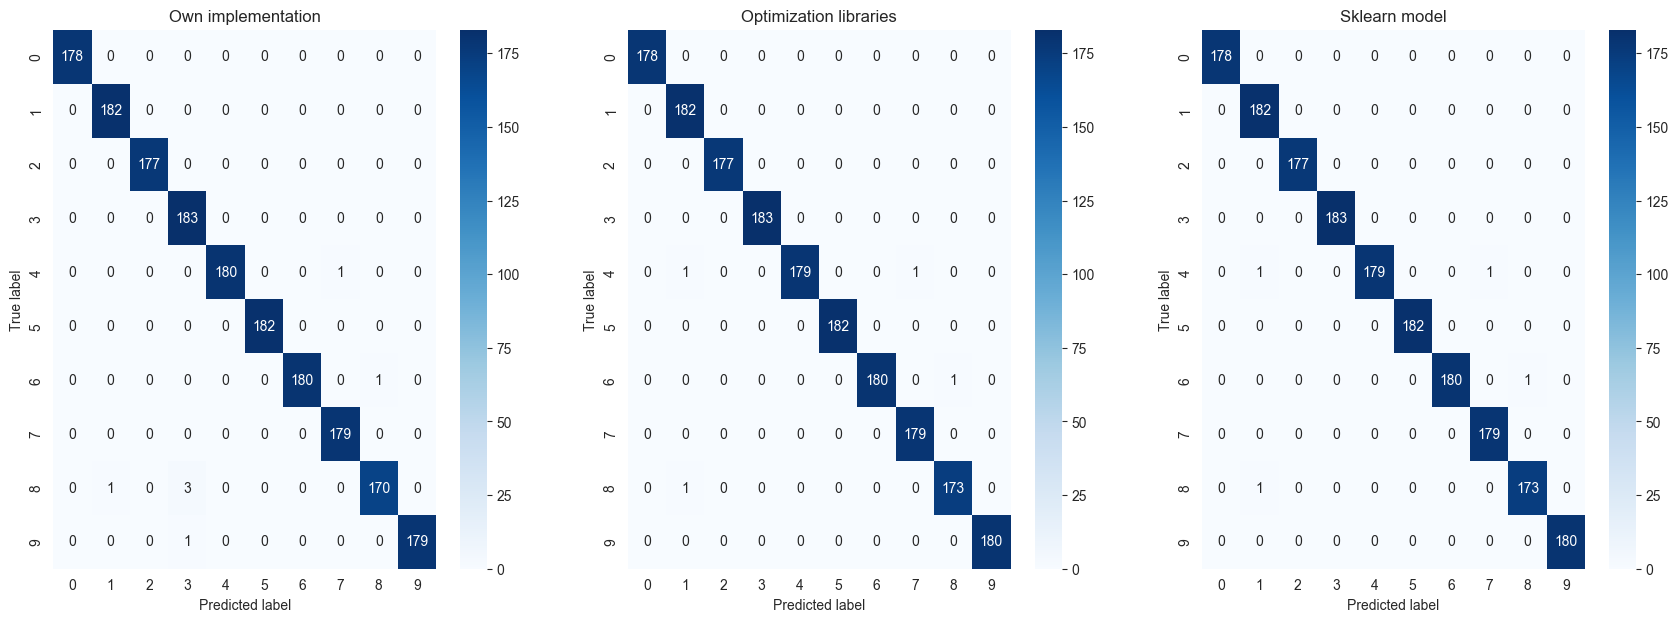

In [256]:
# Confusion matrix comparison
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
conf_matrix_digits_svm = confusion_matrix(y_digits, predictions_digits_svm)
plot_confusion_matrix(conf_matrix_digits_svm, classes=[str(i) for i in range(10)], axis=axs[0], title='Own implementation')

# Using optimization libraries
conf_matrix_digits_svm_opt = confusion_matrix(y_digits, predictions_digits_svm_opt)
plot_confusion_matrix(conf_matrix_digits_svm_opt, classes=[str(i) for i in range(10)], axis=axs[1], title='Optimization libraries')

# Sklearn model
conf_matrix_digits_svm_sklearn = confusion_matrix(y_digits, predictions_digits_svm_sklearn)
plot_confusion_matrix(conf_matrix_digits_svm_sklearn, classes=[str(i) for i in range(10)], axis=axs[2], title='Sklearn model')

plt.show()

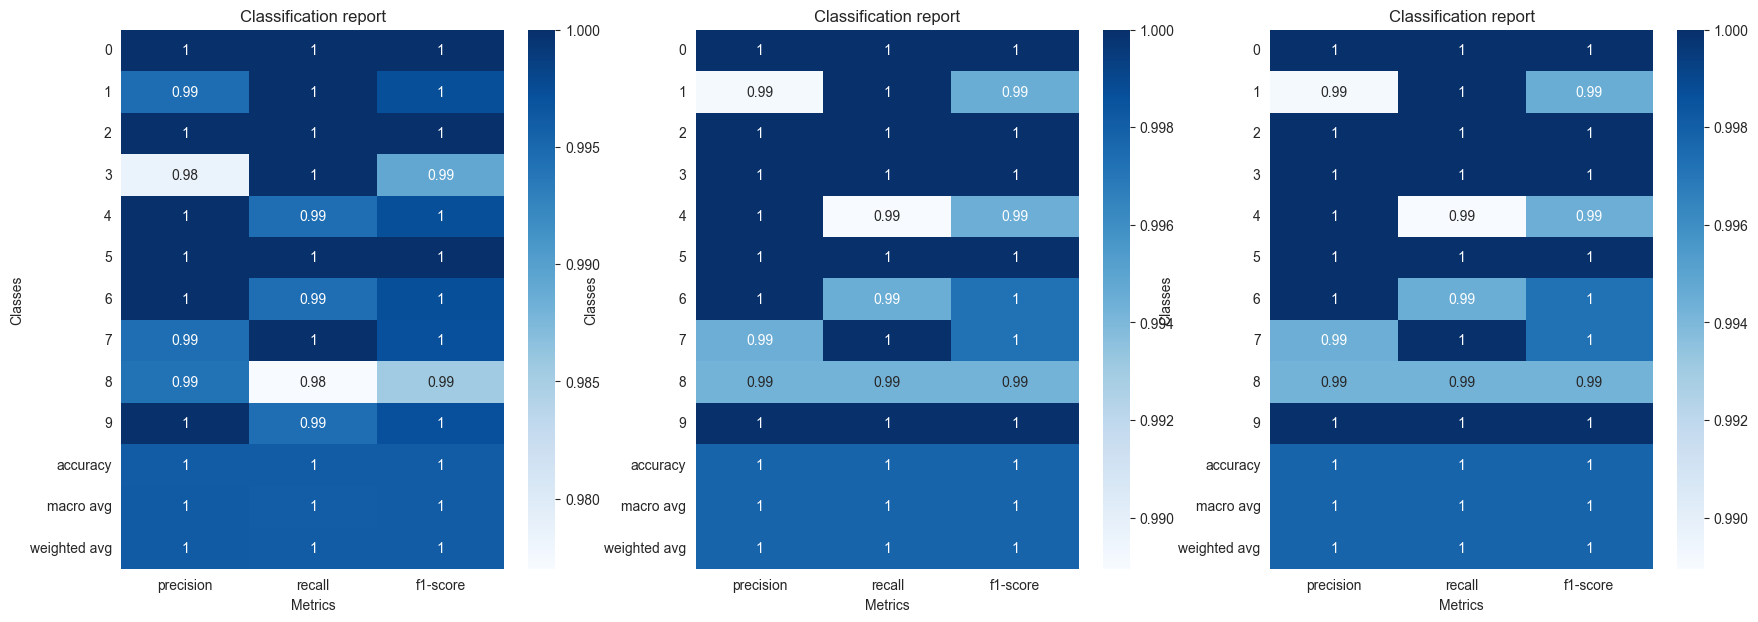

In [257]:
# Classification report
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
report_digits_svm = classification_report(y_digits, predictions_digits_svm, target_names=[str(i) for i in range(10)], output_dict=True)
plot_classification_report(report_digits_svm, axis=axs[0], title='Own implementation')

# Using optimization libraries
report_digits_svm_opt = classification_report(y_digits, predictions_digits_svm_opt, target_names=[str(i) for i in range(10)], output_dict=True)
plot_classification_report(report_digits_svm_opt, axis=axs[1], title='Optimization libraries')

# Sklearn model
report_digits_svm_sklearn = classification_report(y_digits, predictions_digits_svm_sklearn, target_names=[str(i) for i in range(10)], output_dict=True)
plot_classification_report(report_digits_svm_sklearn, axis=axs[2], title='Sklearn model')

#### Klasyfikacja zbioru heart disease

##### Przygotowanie danych

In [292]:
X_heart, y_heart = heart_disease.drop(columns='target'), heart_disease['target']
y_heart[y_heart == 0] = -1

# Normalize continuous features
scaler_heart = MinMaxScaler()
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_heart[continuous_features] = scaler_heart.fit_transform(X_heart[continuous_features])

# One-hot encoding for categorical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
X_heart = pd.get_dummies(X_heart, columns=categorical_features, dtype=float)

X_heart, y_heart = X_heart.values, y_heart.values

# Train-test split
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(X_heart, y_heart, test_size=0.2, random_state=1234)

##### Disease vs No-disease

In [303]:
# Own implementation with rbf kernel
SVM_heart = SVM(**{'C': 1.0, 'epochs': 1000, 'gamma': 0.1, 'kernel': 'rbf', 'learning_rate': 0.01})
SVM_heart.fit(X_train_heart, y_train_heart)
print(f"Accuracy of own implementation model (train set): {SVM_heart.score(X_train_heart, y_train_heart)}")
print(f"Accuracy of own implementation model (test set): {SVM_heart.score(X_test_heart, y_test_heart)}")

# Using optimization libraries with poly kernel
SVM_heart_opt = SVM_OPT(**{'C': 1.0, 'coef0': 1.0, 'degree': 3, 'epochs': 1000, 'gamma': 1.0, 'kernel': 'poly'})
SVM_heart_opt.fit(X_train_heart, y_train_heart)
print(f"Accuracy of cxvopt model (train set): {SVM_heart_opt.score(X_train_heart, y_train_heart)}")
print(f"Accuracy of cxvopt model (test set): {SVM_heart_opt.score(X_test_heart, y_test_heart)}")

# Sklearn model with rbf kernel
SVM_heart_sklearn = SVC(**{'C': 8.870843089341234, 'gamma': 2.7, 'kernel': 'rbf'})
SVM_heart_sklearn.fit(X_train_heart, y_train_heart)
print(f"Accuracy of sklearn model (train set): {SVM_heart_sklearn.score(X_train_heart, y_train_heart)}")
print(f"Accuracy of sklearn model (test set): {SVM_heart_sklearn.score(X_test_heart, y_test_heart)}")

Accuracy of own implementation model (train set): 1.0
Accuracy of own implementation model (test set): 0.9853658536585366
Accuracy of cxvopt model (train set): 1.0
Accuracy of cxvopt model (test set): 0.9853658536585366
Accuracy of sklearn model (train set): 1.0
Accuracy of sklearn model (test set): 1.0


#### Wyniki klasyfikacji zbioru heart disease

In [304]:
# Own implementation
predictions_heart_svm = SVM_heart.predict(X_heart)

# Using optimization libraries
predictions_heart_svm_opt = SVM_heart_opt.predict(X_heart)

# Sklearn model
predictions_heart_svm_sklearn = SVM_heart_sklearn.predict(X_heart)

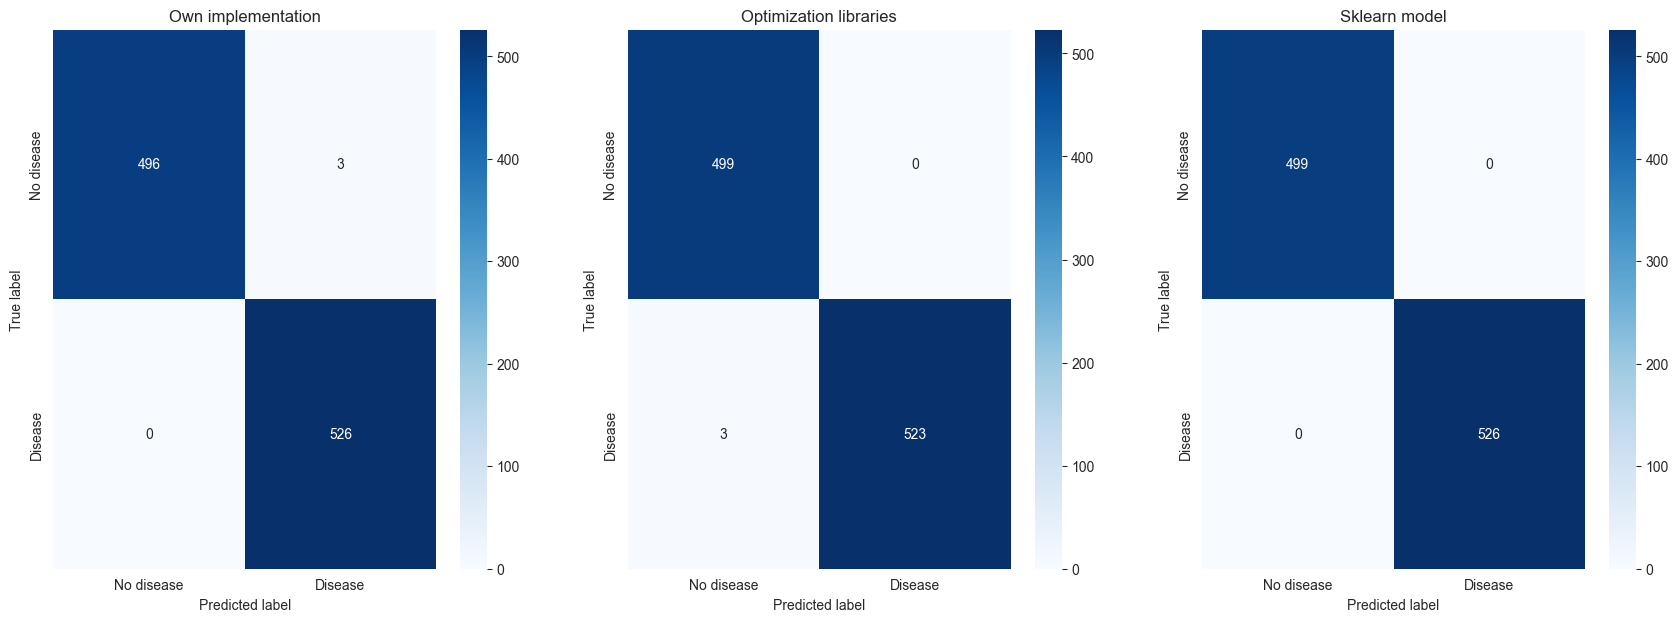

In [305]:
# Confusion matrix comparison
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
conf_matrix_heart_svm = confusion_matrix(y_heart, predictions_heart_svm)
plot_confusion_matrix(conf_matrix_heart_svm, classes=['No disease', 'Disease'], axis=axs[0], title='Own implementation')

# Using optimization libraries
conf_matrix_heart_svm_opt = confusion_matrix(y_heart, predictions_heart_svm_opt)
plot_confusion_matrix(conf_matrix_heart_svm_opt, classes=['No disease', 'Disease'], axis=axs[1], title='Optimization libraries')

# Sklearn model
conf_matrix_heart_svm_sklearn = confusion_matrix(y_heart, predictions_heart_svm_sklearn)
plot_confusion_matrix(conf_matrix_heart_svm_sklearn, classes=['No disease', 'Disease'], axis=axs[2], title='Sklearn model')

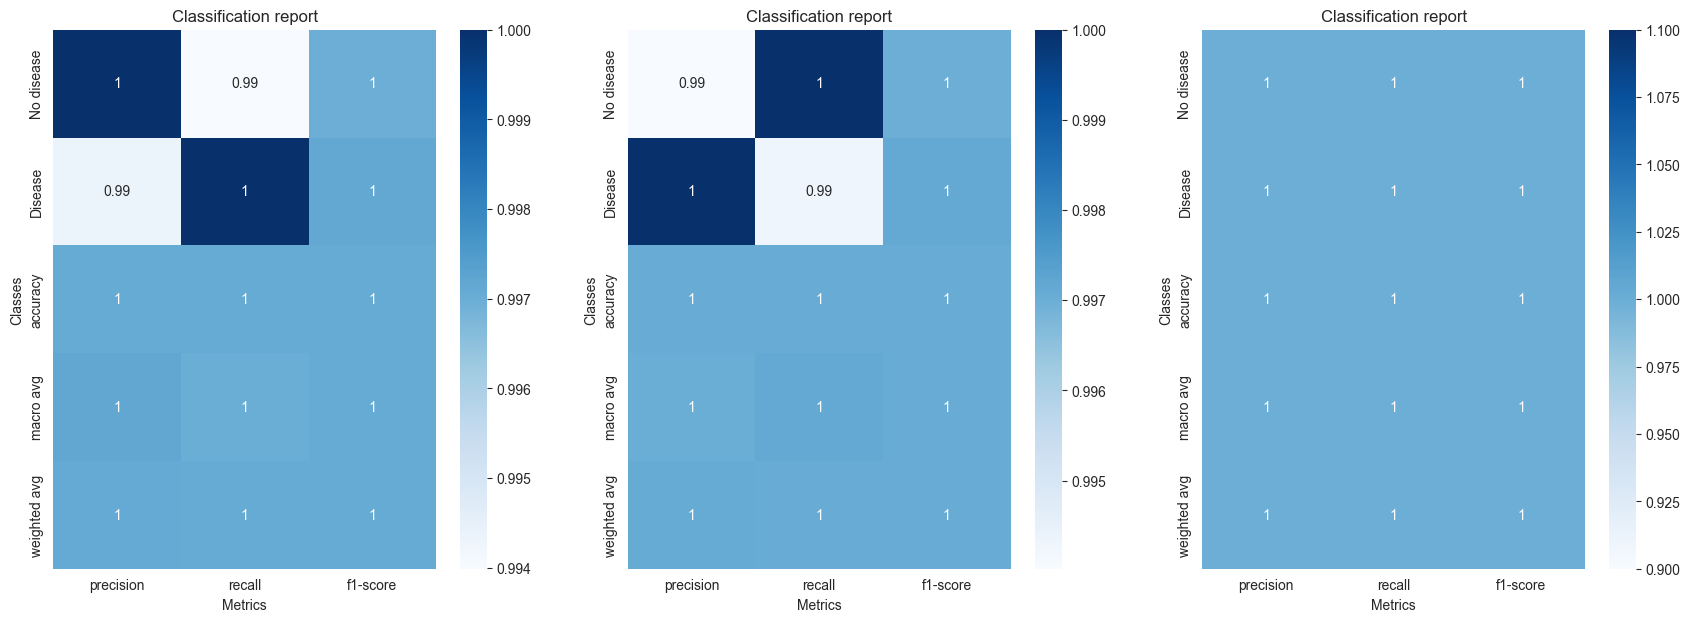

In [306]:
# Classification report
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
report_heart_svm = classification_report(y_heart, predictions_heart_svm, target_names=['No disease', 'Disease'], output_dict=True)
plot_classification_report(report_heart_svm, axis=axs[0], title='Own implementation')

# Using optimization libraries
report_heart_svm_opt = classification_report(y_heart, predictions_heart_svm_opt, target_names=['No disease', 'Disease'], output_dict=True)
plot_classification_report(report_heart_svm_opt, axis=axs[1], title='Optimization libraries')

# Sklearn model
report_heart_svm_sklearn = classification_report(y_heart, predictions_heart_svm_sklearn, target_names=['No disease', 'Disease'], output_dict=True)
plot_classification_report(report_heart_svm_sklearn, axis=axs[2], title='Sklearn model')

#### Klasyfikacja zbioru titanic

##### Przygotowanie danych

In [333]:
titanic = sns.load_dataset('titanic')

# Drop unnecessary columns / columns with too many missing values
titanic.drop(columns=['deck', 'alive', 'alone', 'embark_town', 'who', 'class', 'adult_male'], inplace=True)

# Impute embarked feature
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])

# Impute age feature group by sex, pclass and embarked
titanic['age'] = titanic.groupby(['sex', 'pclass', 'embarked'])['age'].transform(lambda x: x.fillna(x.mean()))

titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,23.223684,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


In [336]:
X_titanic, y_titanic = titanic.drop(columns='survived'), titanic['survived']

# Normalize continuous features
scaler_titanic = MinMaxScaler()
continuous_features = ['age', 'fare']
X_titanic[continuous_features] = scaler_titanic.fit_transform(X_titanic[continuous_features])

# One-hot encoding for categorical features
categorical_features = ['embarked', 'pclass', 'sibsp', 'parch', 'sex']
X_titanic = pd.get_dummies(X_titanic, columns=categorical_features, dtype=float)

X_titanic, y_titanic = X_titanic.values, y_titanic.values
y_titanic[y_titanic == 0] = -1

# Train-test split
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=1234)

##### Survived vs Not-survived

In [353]:
# Own implementation with rbf kernel
SVM_titanic = SVM(**{'C': 1.0, 'epochs': 1000, 'gamma': 0.1, 'kernel': 'rbf', 'learning_rate': 0.01})
SVM_titanic.fit(X_train_titanic, y_train_titanic)
print(f"Accuracy of own implementation model (train set): {SVM_titanic.score(X_train_titanic, y_train_titanic)}")
print(f"Accuracy of own implementation model (test set): {SVM_titanic.score(X_test_titanic, y_test_titanic)}")

# Using optimization libraries with poly kernel
SVM_titanic_opt = SVM_OPT(**{'C': 1.0, 'coef0': 1.0, 'degree': 3, 'epochs': 1000, 'gamma': 1.0, 'kernel': 'poly'})
SVM_titanic_opt.fit(X_train_titanic, y_train_titanic)
print(f"Accuracy of cxvopt model (train set): {SVM_titanic_opt.score(X_train_titanic, y_train_titanic)}")
print(f"Accuracy of cxvopt model (test set): {SVM_titanic_opt.score(X_test_titanic, y_test_titanic)}")

# Sklearn model with poly kernel
SVM_titanic_sklearn = SVC(**{'C': 2.030390825452772, 'coef0': 1.0, 'degree': 2, 'gamma': 4.0, 'kernel': 'poly'})
SVM_titanic_sklearn.fit(X_train_titanic, y_train_titanic)
print(f"Accuracy of sklearn model (train set): {SVM_titanic_sklearn.score(X_train_titanic, y_train_titanic)}")
print(f"Accuracy of sklearn model (test set): {SVM_titanic_sklearn.score(X_test_titanic, y_test_titanic)}")

Accuracy of own implementation model (train set): 0.8946629213483146
Accuracy of own implementation model (test set): 0.7877094972067039
Accuracy of cxvopt model (train set): 0.8581460674157303
Accuracy of cxvopt model (test set): 0.8156424581005587
Accuracy of sklearn model (train set): 0.8441011235955056
Accuracy of sklearn model (test set): 0.8268156424581006


#### Wyniki klasyfikacji zbioru titanic

In [355]:
# Own implementation
predictions_titanic_svm = SVM_titanic.predict(X_titanic)

# Using optimization libraries
predictions_titanic_svm_opt = SVM_titanic_opt.predict(X_titanic)

# Sklearn model
predictions_titanic_svm_sklearn = SVM_titanic_sklearn.predict(X_titanic)

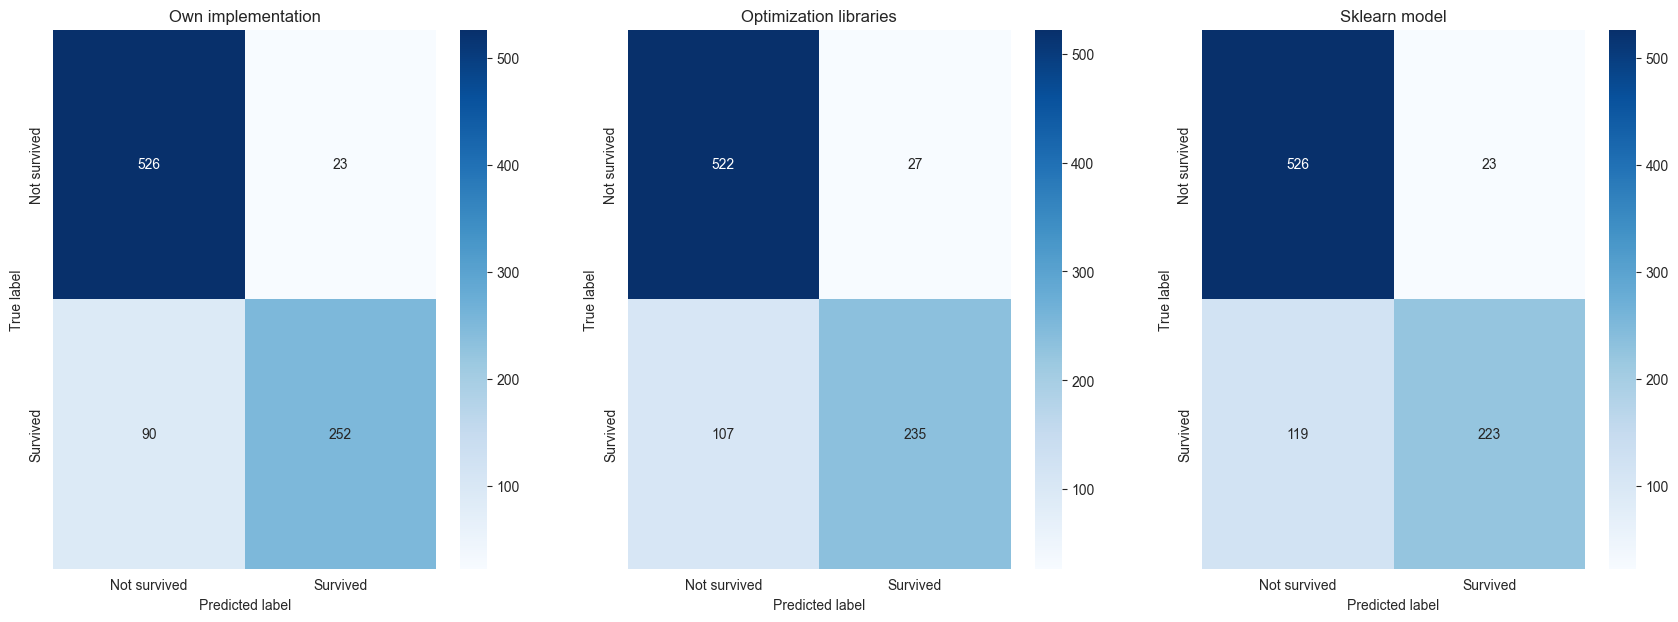

In [356]:
# Confusion matrix comparison
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
conf_matrix_titanic_svm = confusion_matrix(y_titanic, predictions_titanic_svm)
plot_confusion_matrix(conf_matrix_titanic_svm, classes=['Not survived', 'Survived'], axis=axs[0], title='Own implementation')

# Using optimization libraries
conf_matrix_titanic_svm_opt = confusion_matrix(y_titanic, predictions_titanic_svm_opt)
plot_confusion_matrix(conf_matrix_titanic_svm_opt, classes=['Not survived', 'Survived'], axis=axs[1], title='Optimization libraries')

# Sklearn model
conf_matrix_titanic_svm_sklearn = confusion_matrix(y_titanic, predictions_titanic_svm_sklearn)
plot_confusion_matrix(conf_matrix_titanic_svm_sklearn, classes=['Not survived', 'Survived'], axis=axs[2], title='Sklearn model')

plt.show()

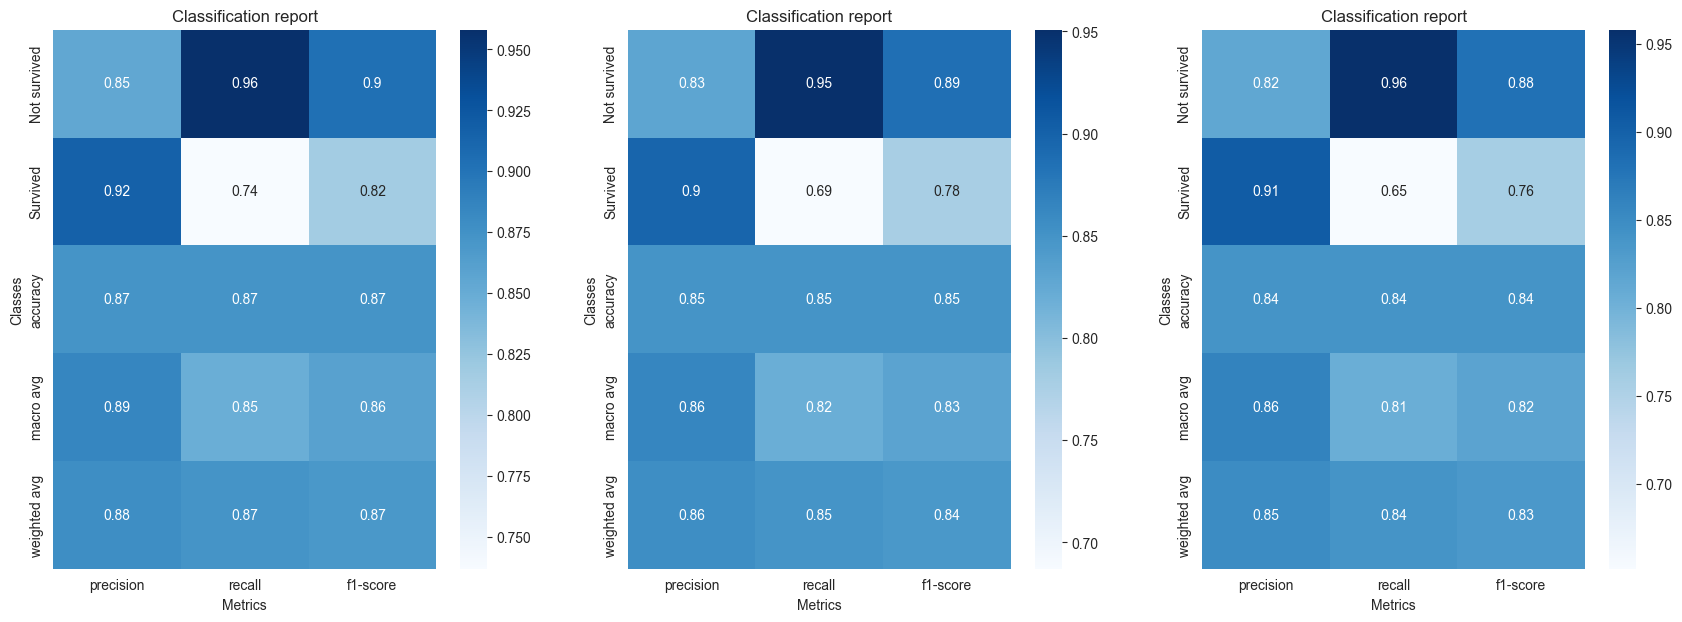

In [358]:
# Classification report
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# Own implementation
report_titanic_svm = classification_report(y_titanic, predictions_titanic_svm, target_names=['Not survived', 'Survived'], output_dict=True)
plot_classification_report(report_titanic_svm, axis=axs[0], title='Own implementation')

# Using optimization libraries
report_titanic_svm_opt = classification_report(y_titanic, predictions_titanic_svm_opt, target_names=['Not survived', 'Survived'], output_dict=True)
plot_classification_report(report_titanic_svm_opt, axis=axs[1], title='Optimization libraries')

# Sklearn model
report_titanic_svm_sklearn = classification_report(y_titanic, predictions_titanic_svm_sklearn, target_names=['Not survived', 'Survived'], output_dict=True)
plot_classification_report(report_titanic_svm_sklearn, axis=axs[2], title='Sklearn model')

plt.show()

#### Podsumowanie

* Przeprowadzone eksperymenty pokazują, że zaimplementowany klasyfikator SVM działa poprawnie i zwraca wyniki zbliżone do wyników z biblioteki sklearn. 
* Wyniki uzyskiwane przez wszystkie klasyfikatory są porównywalne.
* Parametry modeli zostały dobrane z wykorzystaniem tuningu hiperparametrów. W modelach zastosowano rożne funkcje jądra, takie jak rbf, poly, sigmoid i linear.
* Wybór jądra wpływa na jakość modelu. Jądro powinno być dobrane odpowiednio do danych, które są klasyfikowane. Dla danych liniowo separowalnych wystarczy jądro liniowe. Dla danych nieliniowych lepiej sprawdzają się jądra nieliniowe, takie jak rbf, poly czy sigmoid.